#Description

##Background: Equity in Healthcare
Healthcare inequity is a global challenge. Addressing this challenge has an extensive positive impact on women’s health, which is key for societies and economies to thrive. This datathon is designed to help discover whether disparate treatments exist and to understand the drivers of those biases, such as demographic and societal factors.

In the first datathon challenge we explored the relationship between socio economic aspects that contribute to health equity. For this next challenge we’re building on that analysis to see how climate patterns impact access to healthcare.

##Overview: The Dataset and Challenge
Gilead Sciences is the sponsor for the 2024 WiDS Datathon.The dataset originated from Health Verity, one of the largest healthcare data ecosystems in the US. It was enriched with third party geo-demographic data to provide views into the socio economic aspects that may contribute to health equity. For this challenge, the dataset was then further enriched with zip code level climate data.

##Challenge task:
Predicting the duration of time it takes for patients to receive metastatic cancer diagnosis.

###Why is this important?
Metastatic TNBC is considered the most aggressive TNBC and requires urgent and timely treatment. Unnecessary delays in diagnosis and subsequent treatment can have devastating effects in these difficult cancers. Differences in the wait time to get treatment is a good proxy for disparities in healthcare access.

The **primary goal** of building these models is to detect relationships between demographics of the patient with the likelihood of getting timely treatment. The **secondary goal** is to see if climate patterns impact proper diagnosis and treatment.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
# import statsmodels.api as sm
# from sklearn.preprocessing import LabelBinarizer

# Importing Data and Initial Data exploration

In [3]:
train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/train.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/test.csv')
solution_template = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')
# shuffle the training set - helps prevent bias during training
train = train.reindex(np.random.permutation(train.index))
display(train.head(5))

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
4992,391341,NaN,COMMERCIAL,OH,448,Midwest,East North Central,39,F,32.62,...,42.62,65.91,71.26,74.03,73.94,69.12,53.50,36.43,34.10,357
11167,309421,NaN,COMMERCIAL,OH,431,Midwest,East North Central,53,F,NaN,...,46.47,70.32,72.84,74.48,75.77,70.97,55.81,38.23,35.95,159
2104,873114,White,COMMERCIAL,MI,486,Midwest,East North Central,59,F,20.86,...,35.99,61.79,65.99,71.99,71.31,63.30,46.41,31.94,29.14,191
8613,749046,NaN,MEDICARE ADVANTAGE,IN,461,Midwest,East North Central,71,F,NaN,...,45.86,71.10,74.27,74.89,74.57,70.70,55.43,37.13,35.43,246
6690,908975,NaN,COMMERCIAL,TX,762,South,West South Central,64,F,37.00,...,57.69,76.24,83.41,86.80,82.78,75.20,63.23,49.48,45.18,15


In [4]:
# Let's print out the size of the dataset
print("Number of rows and columns on training set are: ", train.shape)
print("Number of rows and columns on test set are: ", test.shape)

Number of rows and columns on training set are:  (13173, 152)
Number of rows and columns on test set are:  (5646, 151)


In [5]:
display(solution_template.head(5))
print(solution_template.shape)

,patient_id,metastatic_diagnosis_period
0,730681,100
1,334212,0
2,571362,100
3,907331,100
4,208382,100


(5646, 2)


In [6]:
# Let's print a concise summary of train dataset.
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13173 entries, 4992 to 98
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.4+ MB


From the summary, we see that we have 11 categorical features

In [7]:
# Let's print a concise summary of test dataset.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Columns: 151 entries, patient_id to Average of Dec-18
dtypes: float64(137), int64(3), object(11)
memory usage: 6.5+ MB


In [8]:
#Let's print out the categorical columns and the numerical columns

#Categorical:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
# print('Categorical Columns: ')
# for value in cat_cols:
#     print(value)
print('Categorical Columns: ', cat_cols)

#Numerical:
num_cols = []
for col in train.columns:
  if train[col].dtype == 'int64' or 'float64': #(you could also use != 'object')
    num_cols.append(col)
print('Numerical Columns: ')
for val in num_cols:
    print(val)


Categorical Columns:  ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
Numerical Columns: 
patient_id
patient_race
payer_type
patient_state
patient_zip3
Region
Division
patient_age
patient_gender
bmi
breast_cancer_diagnosis_code
breast_cancer_diagnosis_desc
metastatic_cancer_diagnosis_code
metastatic_first_novel_treatment
metastatic_first_novel_treatment_type
population
density
age_median
age_under_10
age_10_to_19
age_20s
age_30s
age_40s
age_50s
age_60s
age_70s
age_over_80
male
female
married
divorced
never_married
widowed
family_size
family_dual_income
income_household_median
income_household_under_5
income_household_5_to_10
income_household_10_to_15
income_household_15_to_20
income_household_20_to_25
income_household_25_to_35
income_household_35_to_50
income_household_50_

Let's find the number of unique values in each feature

In [9]:
unique_values = pd.concat(
    [
        train.drop('metastatic_diagnosis_period', axis=1).nunique().rename('train'),
        test.nunique().rename('test')
    ],
    axis=1
)

display(unique_values.T)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
train,13173,5,3,44,751,4,8,67,1,1304,...,677,654,634,643,603,613,639,664,661,663
test,5646,5,3,44,669,4,8,67,1,838,...,610,593,575,589,548,551,570,598,597,599


# Plotting categorical features

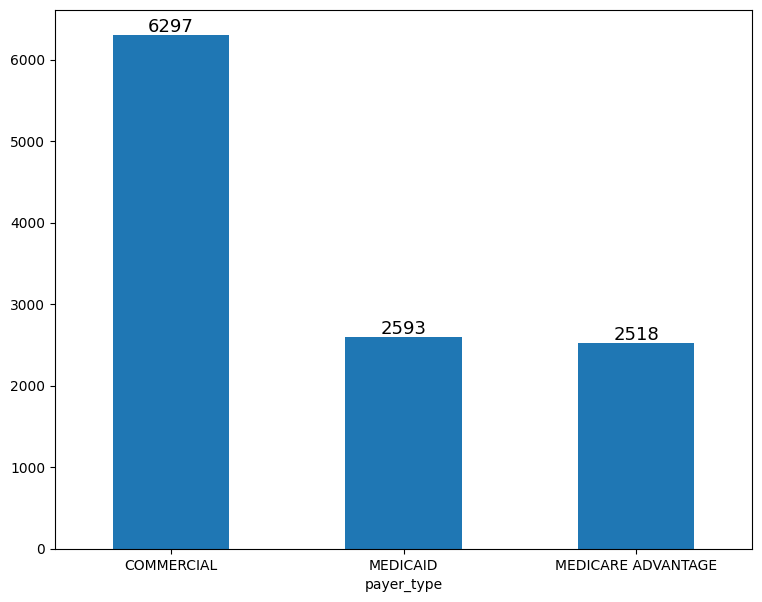

In [10]:
#Let's plot some of the categorical columns

# Creating a barplot for 'payer_ type'

# Setting the width and height of the figure
plt.figure(figsize=(9, 7))

# Bar chart
bars = train['payer_type'].value_counts().plot(kind='bar')

# Setting the value count and fontsize of each bar labels (2103, 882...)
bars.bar_label(bars.containers[0],fontsize = 13)

# Setting the size of the xticks, yticks, and rotating the tick labels to be horizontal
bars.tick_params(labelsize = 10, labelrotation = 360)
plt.show()

We see that the number of people using medicare advantage and medicaid are pretty similar. Over half of the patients used commercial payments. Would be nice to explore what commercial here means. Does it mean cash or company sponsored insurances like Anthem and Blue Cross Blue shield?

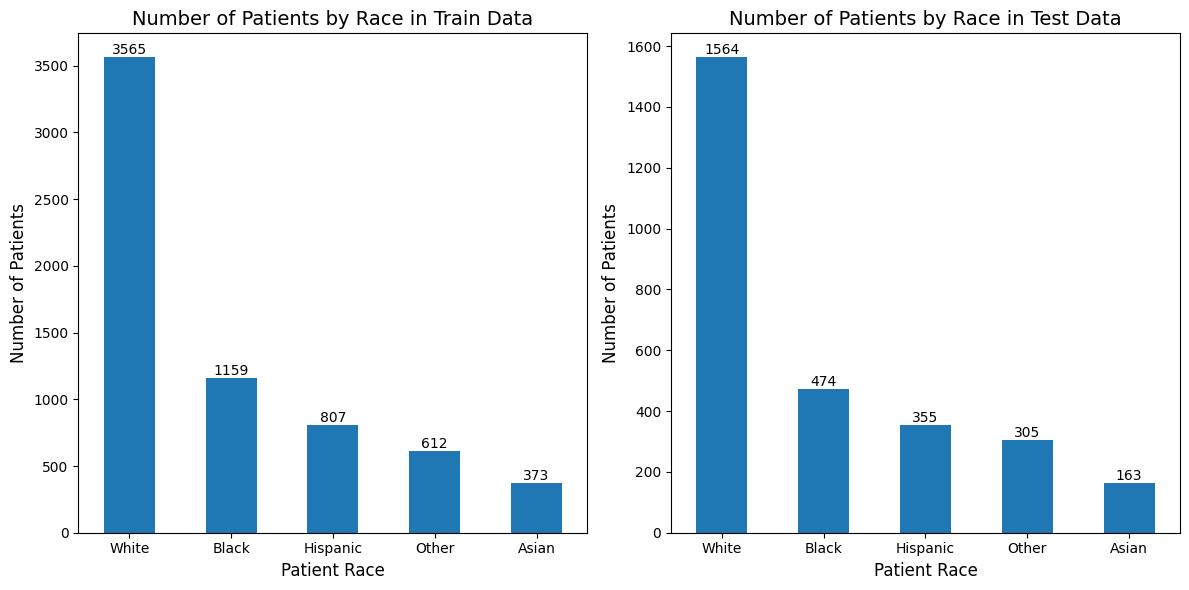

In [11]:
# Creating a Bar Chart of Patient Race

# Setting the width and height of the figure
plt.figure(figsize=(12, 6))

# Bar chart for train data
plt.subplot(121)
bars = train['patient_race'].value_counts().plot(kind='bar')
# You can also use seaborn to create the bars:
# bars = sns.barplot(y = train.index, x = train['patient_race'])
# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patients by Race in Train Data",fontsize = 14)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)

# Bar chart for test data
plt.subplot(122)
bars = test['patient_race'].value_counts().plot(kind='bar')
# You can also use seaborn to create the bars:
# bars = sns.barplot(y = train.index, x = train['patient_race'])
# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patients by Race in Test Data",fontsize = 14)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)

plt.tight_layout()
plt.show()

Patient race data is heavily skewed with the number of patients identifying as white exceeding all other races combined.

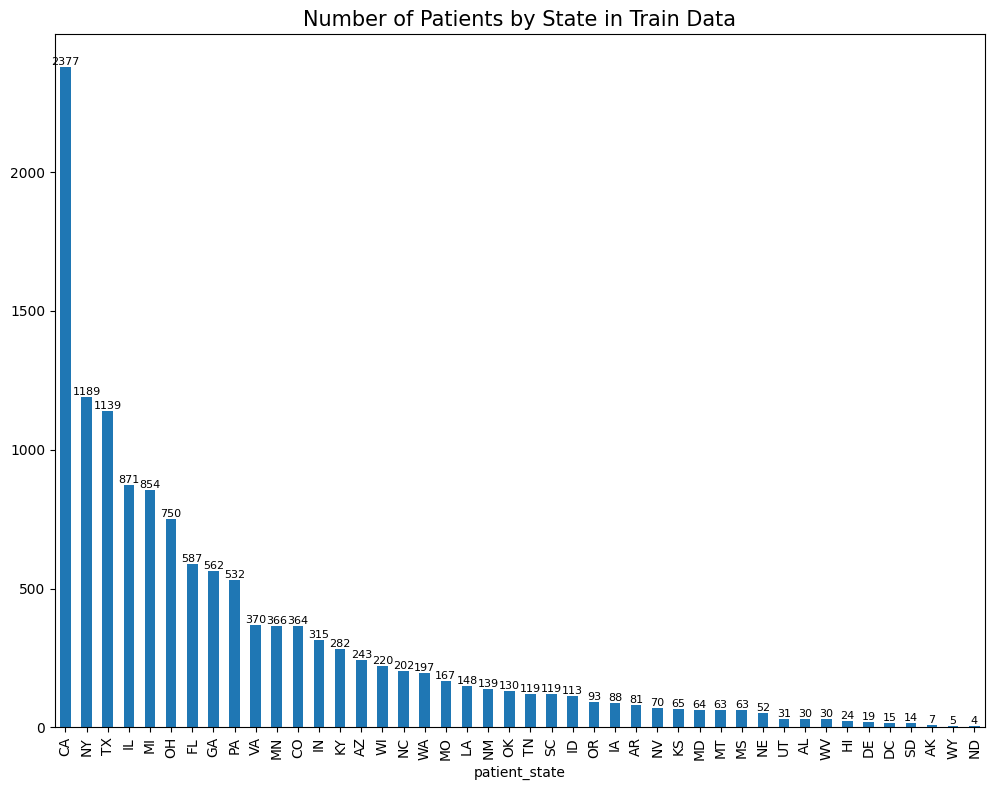

In [12]:
# Creating a Bar Plot of Patient State

# Setting the width and height of the figure
plt.figure(figsize=(12, 9))

# Bar chart
bars = train['patient_state'].value_counts().plot(kind='bar')

# # Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 8)

# # Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patients by State in Train Data",fontsize = 15)
# bars.set_xlabel("Patient Race",fontsize = 15)
# bars.set_ylabel("Number of Patients",fontsize = 15)
# # Setting the size of the xticks and yticks
# bars.tick_params(labelsize = 10, labelrotation = 360)
plt.show()

From the barplot, California(CA) has the highest number of patients followed by New York(NY) and Texas(TX).

One reasonable explanation could be because they are the most populated states.

It would also be great to look into other factors such as food quality, air quality etc. that may explain why these three states have the highest number of cancer patients.

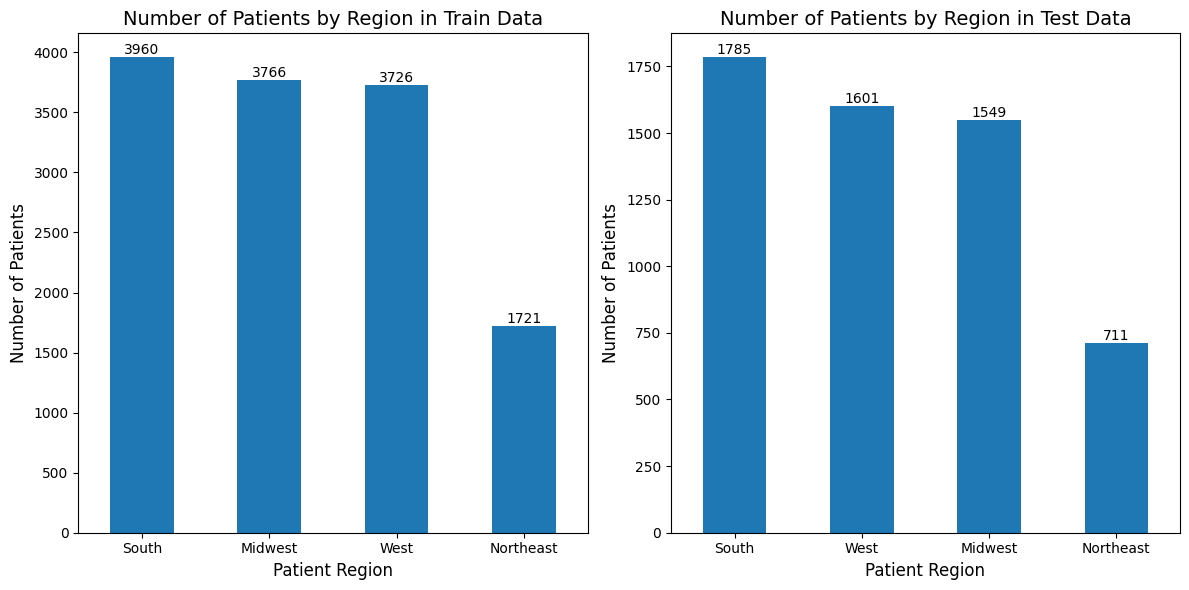

In [13]:
# Creating a Bar Plot of Patient Region

# Setting the width and height of the subplots
plt.figure(figsize=(12, 6))

# Bar chart for train data
plt.subplot(121) #(using plt.subplot to create subplots)
bars = train['Region'].value_counts().plot(kind='bar')
# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patients by Region in Train Data",fontsize = 14)
bars.set_xlabel("Patient Region",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)

# Bar chart for test data
plt.subplot(122)
bars = test['Region'].value_counts().plot(kind='bar')
# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patients by Region in Test Data",fontsize = 14)
bars.set_xlabel("Patient Region",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)

plt.tight_layout()
plt.show()

Northeast region seems to have the least amount of cancer patients. The data doesn't describe exactly what states are considered to be in each region, so it can be hard to draw further value from the plot above.

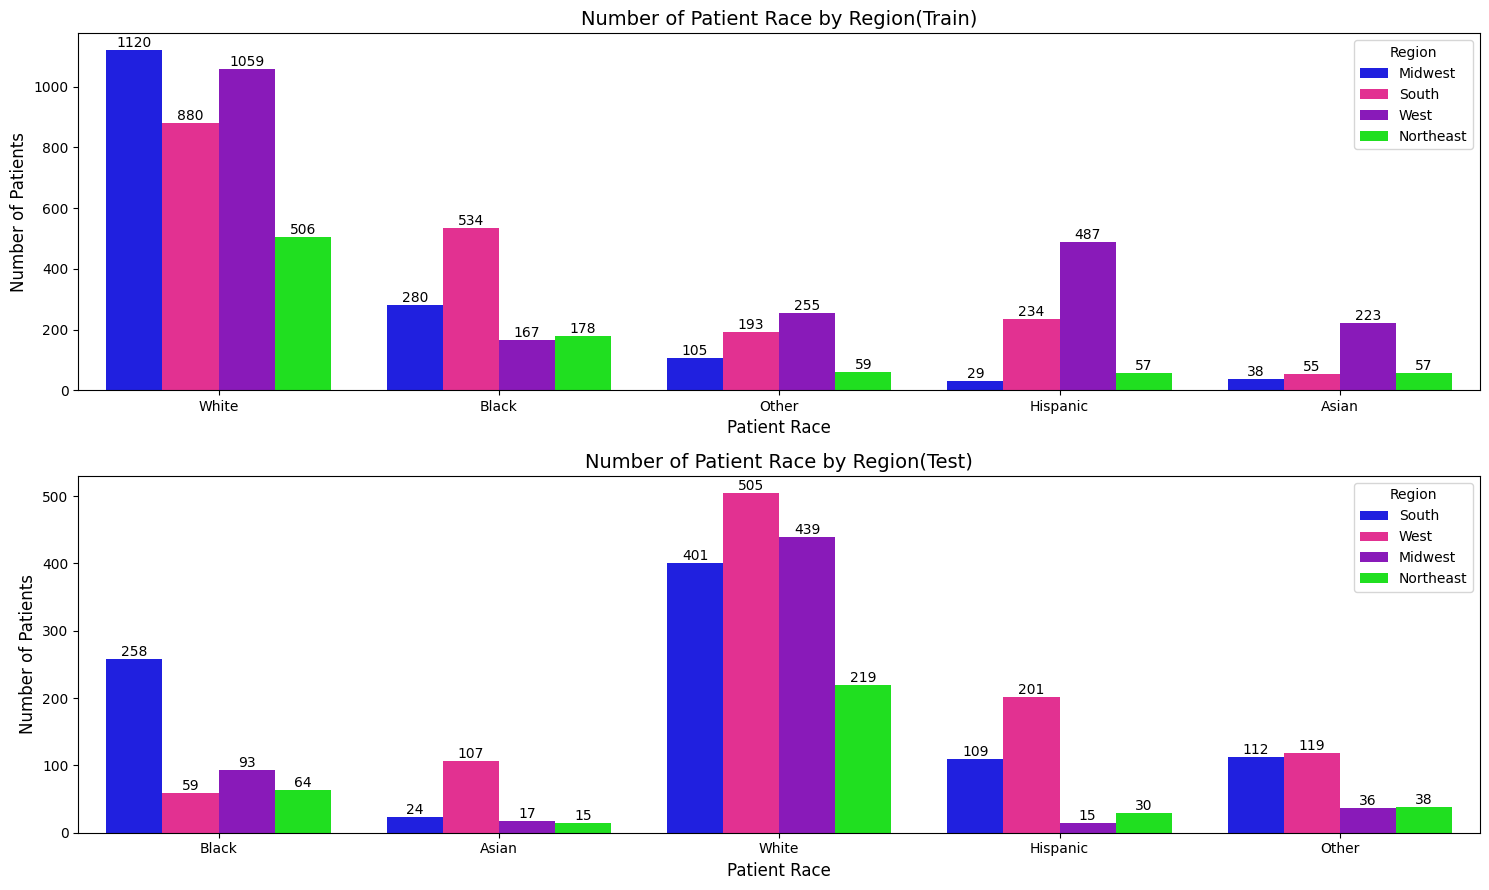

In [14]:
# Plotting the distribution of patient races by region

# Since the patient race is a categorical feature, we'll try using a countplot variation to plot the distribution.
# A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable.
# The basic API and options are identical to those for barplot(), so you can compare counts across nested variables.

# Setting the width and height of the subplots
plt.figure(figsize=(15, 9))

# Plot for train data
plt.subplot(211) #(no. of rows = 2, no. of cols = 1, plot no.1)
bars = sns.countplot(x = train['patient_race'], hue = train['Region'], palette = ['blue', 'deeppink','darkviolet','lime'])

# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
bars.bar_label(bars.containers[1],fontsize = 10)
bars.bar_label(bars.containers[2],fontsize = 10)
bars.bar_label(bars.containers[3],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patient Race by Region(Train)",fontsize = 14)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)


# Plot for test data
plt.subplot(212) #(no. of rows = 2, no. of cols = 1, plot no.2)
bars = sns.countplot(x = test['patient_race'], hue = test['Region'], palette = ['blue', 'deeppink','darkviolet','lime'])

# Setting the size of inside bar labels
bars.bar_label(bars.containers[0],fontsize = 10)
bars.bar_label(bars.containers[1],fontsize = 10)
bars.bar_label(bars.containers[2],fontsize = 10)
bars.bar_label(bars.containers[3],fontsize = 10)
# Setting the title, xlabel, ylabel for the plot and their sizes
bars.axes.set_title("Number of Patient Race by Region(Test)",fontsize = 14)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)
# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 360)

plt.tight_layout()
plt.show()

# Plotting numerical features

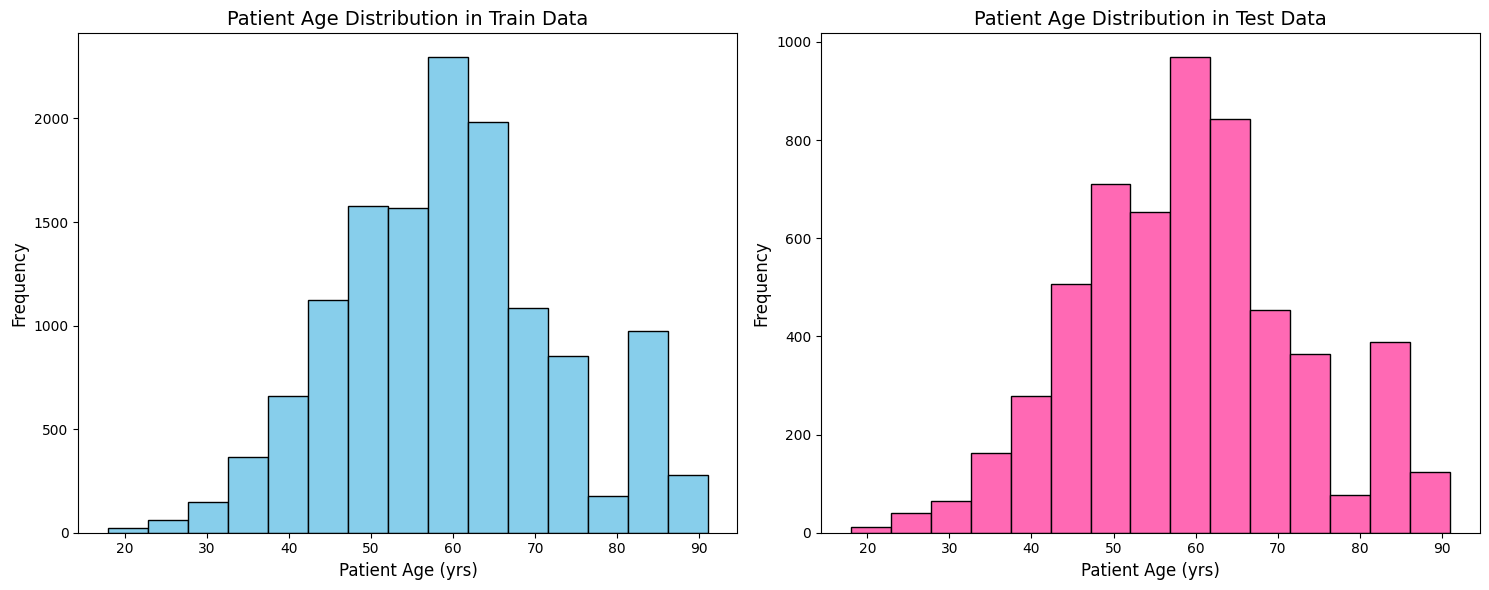

In [15]:
# Plotting some numerical features

# Creating a Histogram for Patient Age

# Create subplots(using plt.subplots) with 1 row and 2 columns and their width and height(figsize)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot for patient_age in train data
axes[0].hist(train['patient_age'], bins=15, color='skyblue', edgecolor='black')
# Setting the title, xlabel, ylabel for the plot and their sizes
axes[0].set_title('Patient Age Distribution in Train Data', fontsize = 14)
axes[0].set_xlabel('Patient Age (yrs)', fontsize = 12)
axes[0].set_ylabel('Frequency', fontsize = 12)

# Plot for patient_age in test data
axes[1].hist(test['patient_age'], bins=15, color='hotpink', edgecolor='black')
# Setting the title, xlabel, ylabel for the plot and their sizes
axes[1].set_title('Patient Age Distribution in Test Data', fontsize = 14)
axes[1].set_xlabel('Patient Age (yrs)', fontsize = 12)
axes[1].set_ylabel('Frequency', fontsize = 12)


plt.tight_layout()
plt.show()


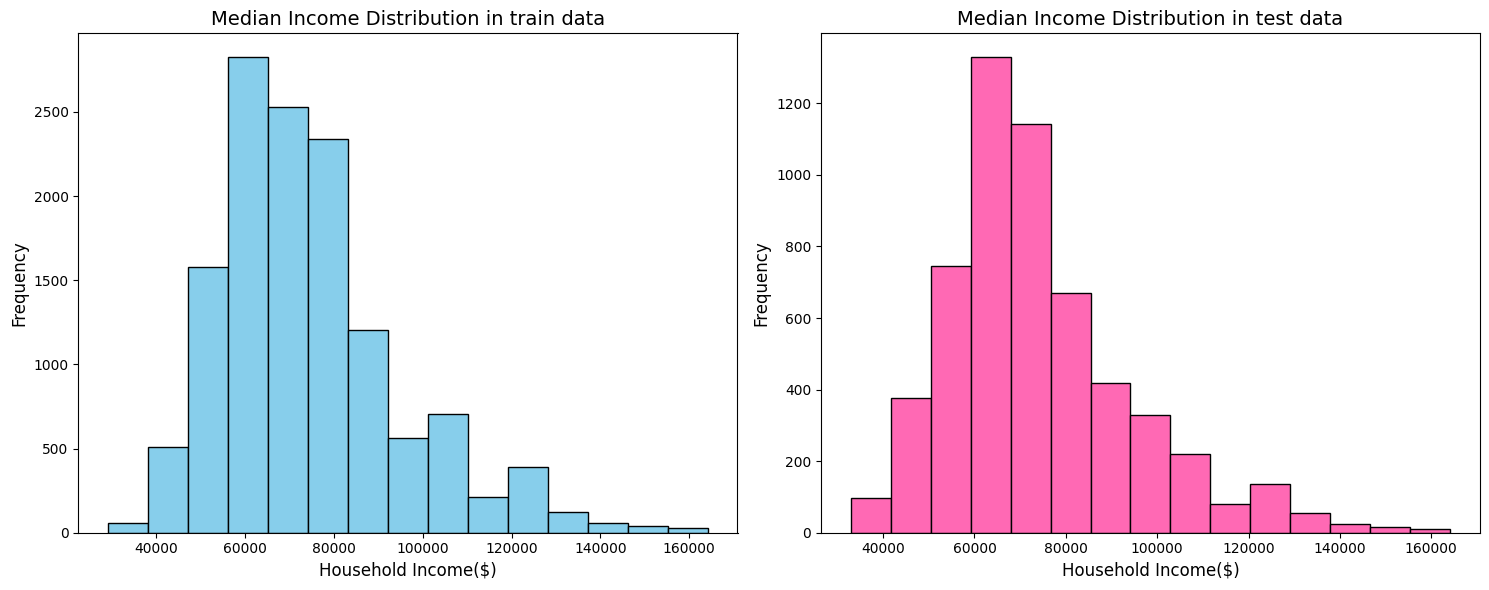

In [16]:
# Income distribution

# Create subplots(using plt.subplots) with 1 row and 2 columns and their width and height(figsize)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Plot for patient_age in train data
# axes[0].hist(train['patient_age'], bins=15, color='skyblue', edgecolor='black')
income_median_train = train['income_household_median'].median()
axes[0].hist(train['income_household_median'], bins=15, color='skyblue', edgecolor='black')

# Setting the title, xlabel, ylabel for the plot and their sizes
axes[0].set_title('Median Income Distribution in train data', fontsize = 14)
axes[0].set_xlabel('Household Income($)', fontsize = 12)
axes[0].set_ylabel('Frequency', fontsize = 12)

# Plot for patient_age in test data
income_median_test = test['income_household_median'].median()
axes[1].hist(test['income_household_median'], bins=15, color='hotpink', edgecolor='black')
# Setting the title, xlabel, ylabel for the plot and their sizes
axes[1].set_title('Median Income Distribution in test data', fontsize = 14)
axes[1].set_xlabel('Household Income($)', fontsize = 12)
axes[1].set_ylabel('Frequency', fontsize = 12)
plt.tight_layout()
plt.show()


# More Exploratory Analysis

In [17]:
train['patient_gender'].info()

<class 'pandas.core.series.Series'>
Index: 13173 entries, 4992 to 98
Series name: patient_gender
Non-Null Count  Dtype 
--------------  ----- 
13173 non-null  object
dtypes: object(1)
memory usage: 205.8+ KB


From the info above, we see that all patients identified as Female. So we do not need to plot a chart for the patient gender.

Let's take a deeper look into the metastatic diagnosis period

In [18]:
train['metastatic_diagnosis_period'].describe()

count    13173.000000
mean        96.515221
std        108.969873
min          0.000000
25%          3.000000
50%         44.000000
75%        181.000000
max        365.000000
Name: metastatic_diagnosis_period, dtype: float64

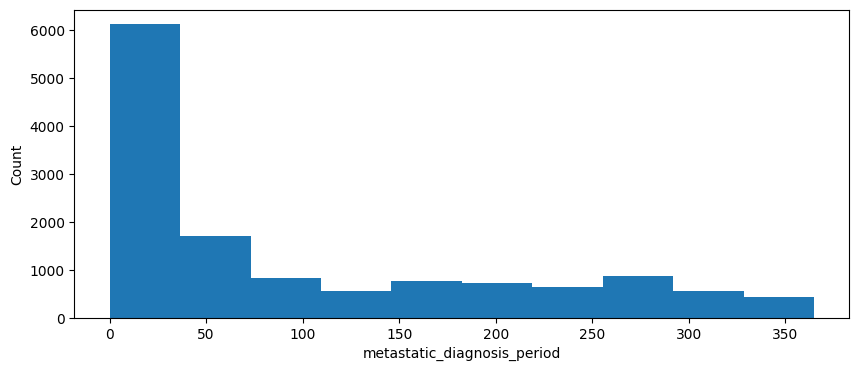

In [19]:
# Distribution of the metastatic diagnosis period feature
plt.figure(figsize = (10, 6))
target_dist = train['metastatic_diagnosis_period'].plot(kind='hist', figsize=(10, 4), xlabel='metastatic_diagnosis_period', ylabel='Count')

Let's look at the mean and median of this feature for each race

In [20]:
# Let's find the count for when the metastatic diagnosis period was zero days

zero_count = (train['metastatic_diagnosis_period'] == 0).sum()
print("The amount of metastatic diagnoses that took 0 days are: ", zero_count)

The amount of metastatic diagnoses that took 0 days are:  3126


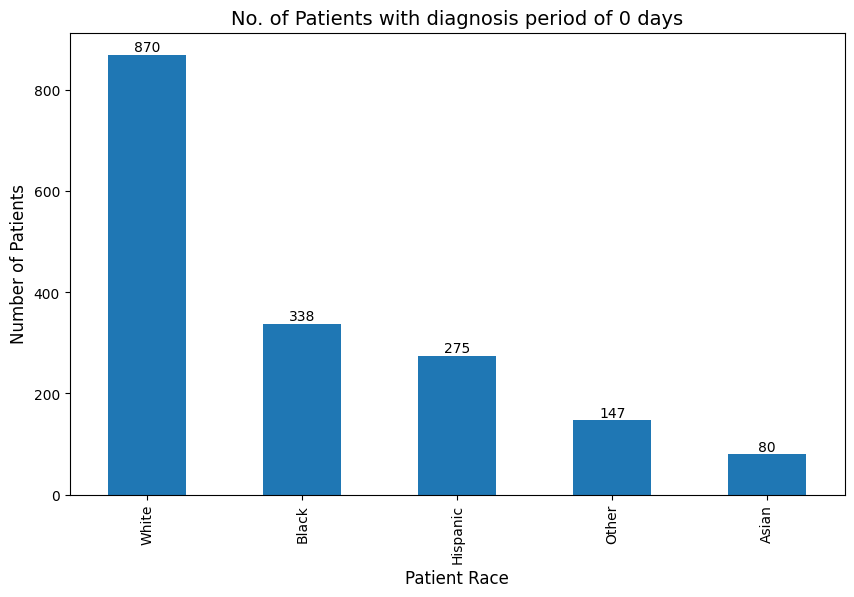

In [21]:
# Let's take this a step further, and check zero_count for each patient race

# Creating a new dataframe where metastatic diagnosis period is 0 days.
zero_days_train = train[train['metastatic_diagnosis_period'] == 0]

# Plotting this in relation to patient race
plt.figure(figsize=(10, 6)) # Setting the size of the plot figure

bars = zero_days_train['patient_race'].value_counts().plot(kind='bar')
bars.bar_label(bars.containers[0],fontsize = 10)
bars.axes.set_title("No. of Patients with diagnosis period of 0 days",fontsize = 14)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Number of Patients",fontsize = 12)

plt.show()

We see that white patients have the quickest metastatic diagnosis period compared to other races.

This could also be because white patient population is the largest amongst other race populations.

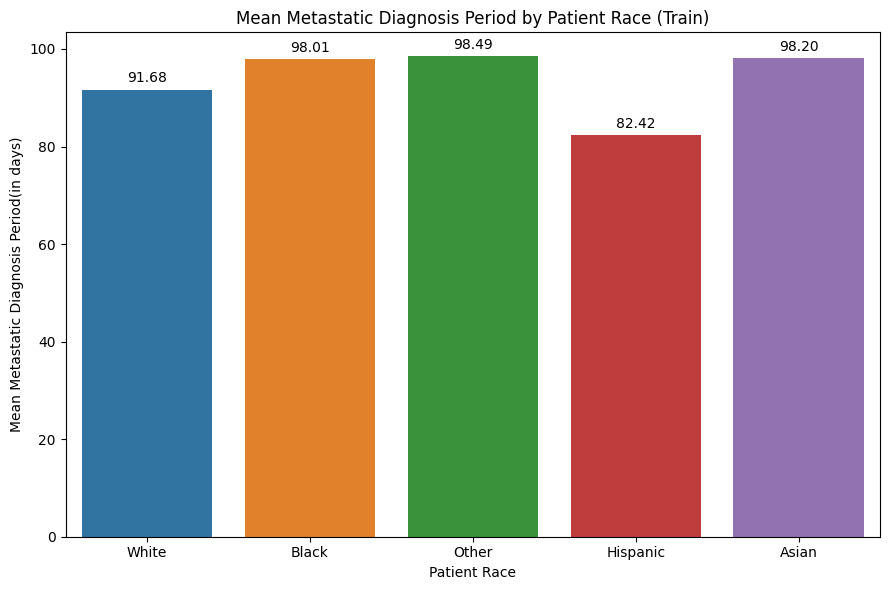

In [22]:
# Mean metastatic diagnosis period for each race

# Setting the size of the plot figure
plt.figure(figsize=(9, 6))

# Plotting the bar graph
ax = sns.barplot(data=train, x='patient_race', y='metastatic_diagnosis_period',  errorbar = None)  # ci=None disables error bars
plt.xlabel('Patient Race')
plt.ylabel('Mean Metastatic Diagnosis Period(in days)')
plt.title('Mean Metastatic Diagnosis Period by Patient Race (Train)')
plt.xticks(rotation = 360)  # Rotating x-axis labels for better readability

# Annotate each bar with its corresponding mean value
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha ='center', va ='center',
                 size = 10, xytext = (0, 8),
                 textcoords = 'offset points')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [23]:
# Getting a summary of the 'breast_cancer_diagnosis_code' feature
print("Statistical summary of 'breast_cancer_diagnosis_code' \n")
train['breast_cancer_diagnosis_code'].info()
print("\nFirst five rows:")
train['breast_cancer_diagnosis_code'].head()


Statistical summary of 'breast_cancer_diagnosis_code' 

<class 'pandas.core.series.Series'>
Index: 13173 entries, 4992 to 98
Series name: breast_cancer_diagnosis_code
Non-Null Count  Dtype 
--------------  ----- 
13173 non-null  object
dtypes: object(1)
memory usage: 205.8+ KB

First five rows:


4992     C50411
11167      1749
2104       1745
8613       1749
6690     C50912
Name: breast_cancer_diagnosis_code, dtype: object

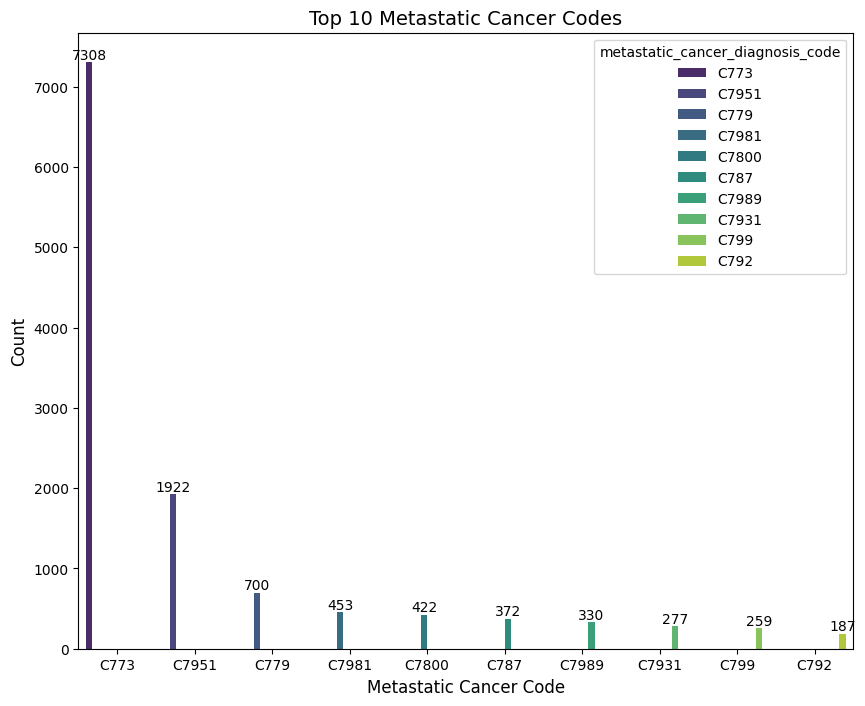

In [24]:
# Let's look at the Top 10 metastatic diagnosis codes

code_counts = train['metastatic_cancer_diagnosis_code'].value_counts()
top_10_codes = code_counts.head(10)
# print("Top 10 Metastatic Diagnosis Codes:")
# print(top_10_codes)

plt.figure(figsize = (10, 8))
ax = sns.barplot(x = top_10_codes.index,hue = top_10_codes.index,y = top_10_codes.values, palette = 'viridis')
for i in range(10): # since we are only showing top 10 codes.
  ax.bar_label(ax.containers[i], fontsize = 10) # prints the count of each bar/container.
plt.title('Top 10 Metastatic Cancer Codes', fontsize = 14)
plt.xlabel('Metastatic Cancer Code', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

# Correlation between Features

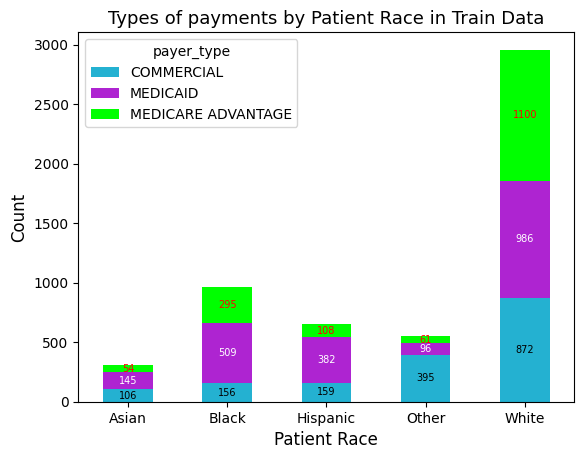

In [25]:
# Let's start with patient race vs payer type

# Plot for Train Data

# We'll create a daframe by crossing patient race and payer type using crosstab function in pandas then plot the dataframe
bars = pd.crosstab(train['patient_race'],train['payer_type']).plot(kind = "bar",stacked = True, color =['#24b1d1', '#ae24d1', '#00FF00'] ) #stacked ensures we plot them ontop of each other

# Setting the labels inside the stacked bars
# Since we have stacked bars, we will use the 3 lines below to find counts of types of paymemnt in each race
# Alternatively, one can use a for loop to pass through containers and save count.
bars.bar_label(bars.containers[0],fontsize = 7, label_type= 'center') #counts on commercial
bars.bar_label(bars.containers[1],fontsize = 7, label_type= 'center', color = 'white') #counts on medicaid
bars.bar_label(bars.containers[2],fontsize = 7, label_type= 'center', color = 'red') #counts on medicare advantage

# Setting the title and xlabel for the plot and their sizes
bars.axes.set_title("Types of payments by Patient Race in Train Data",fontsize = 13)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Count",fontsize = 12)

# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 0)

plt.show()

From the plot above, we first acknowledge that the white race population is the highest, so their payment type counts will overall be larger than the other patients.

White patients seem to be fairly distributed between the 3 payment options with more using medicare advantage.

Black patients more significantly use medicaid as the form of payment rather than Medicare Advantage and Commercial.

Asian patients use commercial and medicare at similar rates with the least being medicare advantage.

Hispanic patients use medicare about twice as much as they use commercial or medicare advantage as forms of payment.

Othe patients use commercial about 4 times as much as they use medicare and about 6 times as much as medicare advantage.

Interestingly, we can also point out that only white patients use medicare advantage more than the other payments Whereas Asian, Black and Hispanic patients use medicaid the most.

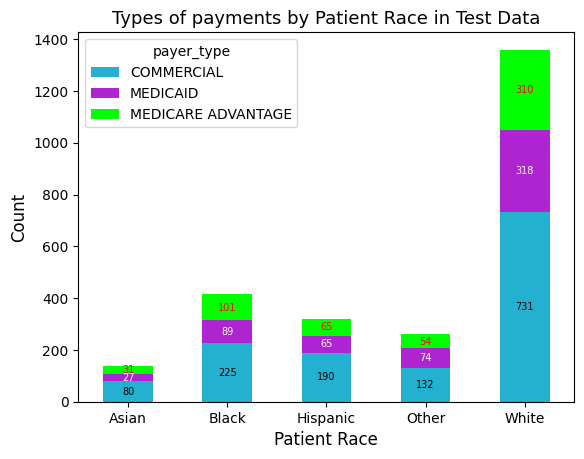

In [26]:
# Plot for Test Data

# We'll create a daframe by crossing patient race and payer type using crosstab function in pandas then plot the dataframe
bars = pd.crosstab(test['patient_race'],train['payer_type']).plot(kind = "bar",stacked = True, color =['#24b1d1', '#ae24d1', '#00FF00'] ) #stacked ensures we plot them ontop of each other

# Setting the labels inside the stacked bars
bars.bar_label(bars.containers[0],fontsize = 7, label_type= 'center') #counts on commercial
bars.bar_label(bars.containers[1],fontsize = 7, label_type= 'center', color = 'white') #counts on medicaid
bars.bar_label(bars.containers[2],fontsize = 7, label_type= 'center', color = 'red') #counts on medicare advantage

# Setting the title and xlabel for the plot and their sizes
bars.axes.set_title("Types of payments by Patient Race in Test Data",fontsize = 13)
bars.set_xlabel("Patient Race",fontsize = 12)
bars.set_ylabel("Count",fontsize = 12)

# Setting the size of the xticks and yticks
bars.tick_params(labelsize = 10, labelrotation = 0)

plt.show()

In test data plot above, we see that commercial is the most used form of payment across all patient races.

We know that socio-economic factors may play an impact into  ones' quality of health from the food they are likely to consume to the health services available to them. Let's plot a correlation heatmap to analyze the relationship between income, poverty and unemployment.

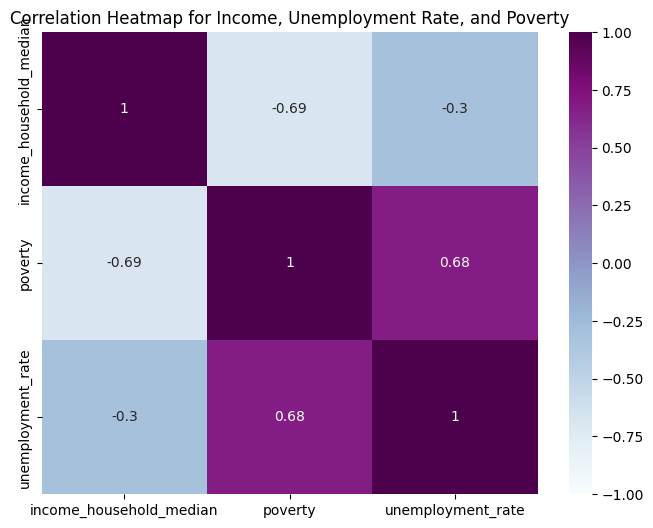

In [27]:
# Correlastion Heatmap
correlation_map_variables = ['income_household_median', 'poverty', 'unemployment_rate']

data = train[correlation_map_variables]

corr_matrix = data.corr()

plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot=True, cmap="BuPu", vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Income, Unemployment Rate, and Poverty')
plt.show()

Poverty in our dataset is measured by the median value of owner occupied homes.

Household income and Poverty have a high correlation of -0.69, showing what we know that the higher the household income, less likely the poverty.

Similarly, Unemployment Rate and Poverty have a high correlation of 0.68, showing that unemployed people are more likely to fall into poverty.


Seeing the presence of multi collinearilty between these features,we'll drop poverty from our dataset.

In [28]:
# Next we'll look at the relationship btw bmi and patient races.
# Before we plot, it's important to note that both of these features have over 50% missing values, so the plot
# insights may be inaccurately represented.

# train[['patient_race','bmi']].mean().plot(kind='bar', color="red")
# train.groupby(['patient_race'])["bmi"].head(5)
# race_bmi = train[["patient_race", "bmi"]]
# race_bmi.plot(kind = "bar")
# race_bmi = train[(train['patient_race']!= 'NaN') & (train['bmi']!= 'NaN')]
# race_bmi_updated = race_bmi[["patient_race", "bmi"]]
# race_bmi_updated.plot(kind = "bar")

In [29]:
# More correlations that could be further explored

# poverty vs patient_race
# income_household vs metastatic_diagnosis_period
# health_uninsured vs metastatic_diagnosis_period
# limited_english vs metastatic_diagnosis_period
# patient_age vs metastatic_diagnosis_period

## Missing Values

In [30]:
# Let's check for missing values in our dataset. Any changes we implement on train set on this section, we'll also implement on test set.

missing_values = ( (train.isna().sum()) / len(train) ) * 100 # gives us percentage of missing values in each column
missing_values = missing_values.drop(missing_values[missing_values == 0].index) # exclude columns with 0 missing values
missing_values = missing_values.sort_values(ascending = False) # Sort missing values in descending order
missing_values.head(15)

metastatic_first_novel_treatment         99.916496
metastatic_first_novel_treatment_type    99.916496
bmi                                      68.860548
patient_race                             50.535186
payer_type                               13.398618
Average of Apr-14                         1.366431
Average of Jun-14                         1.153875
Average of Oct-13                         0.447886
Average of Jul-18                         0.349199
Average of Jan-13                         0.250512
Average of Dec-18                         0.250512
Average of Jul-17                         0.235330
Average of Mar-14                         0.220147
Average of Apr-15                         0.212556
Average of Sep-13                         0.204965
dtype: float64

In [31]:
print("Features with over 10% missing values are: \n", missing_values[missing_values > 10])

Features with over 10% missing values are: 
 metastatic_first_novel_treatment         99.916496
metastatic_first_novel_treatment_type    99.916496
bmi                                      68.860548
patient_race                             50.535186
payer_type                               13.398618
dtype: float64


We see that metastatic first novel treatment has over 99% missing values. With that much data missing, the 2 metastatic features provide close to zero valuable info. Therefore, we will be deleting them

bmi is a valuable feature, but it has over 68% missing values. We will take a closer look to see if we will choose to keep it and do feature engineering or drop it.

For the rest (patient race, payer type, etc..) we will be replacing missing values with averages.

Let's look at the percentage of missing values by columns in both train and test sets

In [32]:
pct_missing = pd.concat(
    [
        (train.drop('metastatic_diagnosis_period', axis=1).isna().sum() / len(train)).rename('train'),
        (test.isna().sum() / len(test)).rename('test')
    ],
    axis=1
)

with pd.option_context('display.precision', 4):
    display(pct_missing.T)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
train,0.0,0.5054,0.134,0.0,0.0,0.0,0.0,0.0,0.0,0.6886,...,0.0005,0.0,0.0,0.0007,0.0035,0.0012,0.0005,0.0005,0.0009,0.0025
test,0.0,0.4933,0.139,0.0,0.0,0.0,0.0,0.0,0.0,0.6980,...,0.0012,0.0,0.0,0.0009,0.0028,0.0012,0.0004,0.0004,0.0014,0.0041


# Data Preprocessing

We'll start by deleting features with the most missing values. From the code above, we see that metastatic_first_novel_treatment and metastatic_first_novel_treatment_type have over 99% missing values. We won't derive any value from them.

We also saw that patient gender has only one unique value(female), so we'll remove it as well since it doesn't derive much insight.

In [33]:
print("Shape before dropping columns: \n")
print("train shape", train.shape)
print("test shape", test.shape)

Shape before dropping columns: 

train shape (13173, 152)
test shape (5646, 151)


In [34]:
df_train = train.drop(columns = ['patient_gender', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'])
df_test = test.drop(columns = ['patient_gender', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)

In [35]:
print("Shape after dropping columns: \n")
print("df_train shape: ", df_train.shape)
print("df_test shape: ", df_test.shape)

Shape after dropping columns: 

df_train shape:  (13173, 149)
df_test shape:  (5646, 148)


Next, we will check for any duplicated rows in our dataset. If we find any, we'll drop the rows.



In [36]:
duplicate_train = df_train[df_train.duplicated() == True]
duplicate_test = df_test[df_test.duplicated() == True]
print(duplicate_train.shape)
print(duplicate_test.shape)

(0, 149)
(0, 148)


We see both train and test sets do not have any duplicate rows

Now, we'll detect and fix outliers/inconsistencies. They appear in the following ways:



*   **Location** based features: patient_zip3, patient_state, Division, Region
<!-- * **Population** based features: population, veteran -->
*   **Temperature** based features: Average of Jan-13, Average of Feb-13...Average of Dec-18
*   Patient **Diagnosis** feature: breast_cancer_diagnosis_code







Let's start by checking if there's more than one state per patient_zip.

Test Set

In [37]:
df_test[['patient_state','patient_zip3']].drop_duplicates().groupby('patient_zip3').count().sort_values('patient_state', ascending=False).head(10)

,patient_state
patient_zip3,
100,1
667,1
672,1
674,1
675,1
676,1
680,1
681,1
683,1


Train Set

In [38]:
df_train[['patient_state','patient_zip3']].drop_duplicates().groupby('patient_zip3').count().sort_values('patient_state', ascending=False).head(10)

,patient_state
patient_zip3,
630,2
864,2
100,1
678,1
668,1
670,1
671,1
672,1
673,1


We see that zip 630 and zip 864 are in 2 states

Let's take a step further and see what these states are for each of the zipcodes. We'll use df.loc property to access a group of rows and columns for the 2 zipcodes.

Using df.loc, we'll create a conditional that returns a boolean series with column labels specified

In [39]:
df_train.loc[df_train['patient_zip3'].isin([630, 864]), ['patient_state', 'patient_zip3']].drop_duplicates()

,patient_state,patient_zip3
12760,AZ,864
11883,MO,630
9229,CA,864
2221,IL,630


So zip 630 shows up in both MO and IL, whereas zip 864 shows up in both AZ and CA.

According to [united states zipcodes](https://www.unitedstateszipcodes.org/) , zip 630 belongs to MO and zip 864 belongs to AZ.

We'll fix the data to reflect that bu using np.where

In [40]:
df_train['patient_state'] = np.where(df_train['patient_zip3'] == 630, 'MO', df_train['patient_state'])
df_train['patient_state'] = np.where(df_train['patient_zip3'] == 864, 'AZ', df_train['patient_state'])

Let's look at state allocation to division. In reality, each state belongs to a single division. Let's check for any inconsistencies

Test Data

In [41]:
df_test[['patient_state','Division']].drop_duplicates().groupby('patient_state').count().sort_values('Division', ascending=False).head(10)

,Division
patient_state,
AK,1
AL,1
NC,1
ND,1
NE,1
NM,1
NV,1
NY,1
OH,1


Train set

In [42]:
df_train[['patient_state','Division']].drop_duplicates().groupby('patient_state').count().sort_values('Division', ascending=False).head(10)

,Division
patient_state,
MO,2
MT,1
NC,1
ND,1
NE,1
NM,1
NV,1
NY,1
OH,1


Let's look at the 2 divisions where MO appears

In [43]:
df_train.loc[df_train['patient_state'] == 'MO', ['patient_state', 'Division']].drop_duplicates()

,patient_state,Division
11883,MO,West North Central
2221,MO,East North Central


Missouri(MO) seems to appear in both West North Central and East North Central.

Let's count the values for each division

In [44]:
df_train.loc[df_train['patient_state'] == 'MO'].value_counts('Division')

Division
West North Central    167
East North Central      1
Name: count, dtype: int64

Since all but 1 are in West North Central, we'll assume it was an error for the single one to be in East North CentraL. So, we'll change it to West North Central.

In [45]:
df_train['Division'] = np.where(df_train['patient_state'] == 'MO', 'West North Central', df_train['Division'])

In [46]:
df_train.loc[df_train['patient_state'] == 'MO', ['patient_state', 'Division']].drop_duplicates()

,patient_state,Division
11883,MO,West North Central


In [47]:
df_train[['patient_state','Division']].drop_duplicates().groupby('patient_state').count().sort_values('Division', ascending=False).head(5)

,Division
patient_state,
AK,1
AL,1
NC,1
ND,1
NE,1


Let's also check for 'region'.

In [48]:
# Test Set
df_test[['patient_state', 'Region']].drop_duplicates().groupby('patient_state').count().sort_values('Region', ascending=False).head(5)

,Region
patient_state,
AK,1
AL,1
NC,1
ND,1
NE,1


In [49]:
# Train Set
df_train[['patient_state','Region']].drop_duplicates().groupby('patient_state').count().sort_values('Region', ascending=False).head(5)

,Region
patient_state,
AK,1
AL,1
NC,1
ND,1
NE,1


Region feature is consistent in both train and test sets. No need for any changes

Next features we'll explore are Temperature related.

In [50]:
df_train['Average of Jan-13'].head()

4992     28.71
11167    31.65
2104     24.06
8613     29.24
6690     45.36
Name: Average of Jan-13, dtype: float64

Let's get a monthly average instead of day averages in each month. This will reduce the number of features in our data set, and make training the ML model more efficient. We should see a decrease in no. of features after this.

In [51]:
df_train.shape

(13173, 149)

In [52]:
# creating a list with 12 months

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Iterating from each month to get average monthly temperature in train
for i in months:
    cols_train = [col for col in df_train.columns if col.startswith(f'Average of {i}')] # putting all day average temperatures of a month in the list
    cols_test = [col for col in df_test.columns if col.startswith(f'Average of {i}')]
    df_train[f'Average of {i}'] = df_train[cols_train].sum(axis = 1)/len(cols_train) # adding all values in cols divide by length to get mean monthly temp.
    df_test[f'Average of {i}'] = df_test[cols_test].sum(axis = 1)/len(cols_train)
    df_train.drop(cols_train, axis = 1, inplace = True) # dropping those columns whose average are taken above
    df_test.drop(cols_test, axis =1, inplace = True)

In [53]:
new_temp_cols = [col for col in df_train.columns if col.startswith('Average of')]
new_temp_colss = [col for col in df_test.columns if col.startswith('Average of')]
print("Train Set: \n",new_temp_cols)
print("Test Set: \n",new_temp_colss)

Train Set: 
 ['Average of Jan', 'Average of Feb', 'Average of Mar', 'Average of Apr', 'Average of May', 'Average of Jun', 'Average of Jul', 'Average of Aug', 'Average of Sep', 'Average of Oct', 'Average of Nov', 'Average of Dec']
Test Set: 
 ['Average of Jan', 'Average of Feb', 'Average of Mar', 'Average of Apr', 'Average of May', 'Average of Jun', 'Average of Jul', 'Average of Aug', 'Average of Sep', 'Average of Oct', 'Average of Nov', 'Average of Dec']


In [54]:
df_train.shape

(13173, 89)

Let's now check for inconsistencies with the breast cancer diagnosis.

Train

In [55]:
df_train.groupby(['breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc'], as_index=False)['patient_id'].count()

,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,patient_id
0,1741,Malignant neoplasm of central portion of femal...,86
1,1742,Malignant neoplasm of upper-inner quadrant of ...,110
2,1743,Malignant neoplasm of lower-inner quadrant of ...,45
3,1744,Malignant neoplasm of upper-outer quadrant of ...,402
4,1745,Malignant neoplasm of lower-outer quadrant of ...,81
5,1746,Malignant neoplasm of axillary tail of female ...,9
6,1748,Malignant neoplasm of other specified sites of...,337
7,1749,"Malignant neoplasm of breast (female), unspeci...",1947
8,19881,Secondary malignant neoplasm of breast,12
9,C5001,"Malignant neoplasm of nipple and areola, female",1


Keep in mind that the last column is no. of patients in each diagnosis code rather than the patient id itself.

We see that there are some diagnosis codes that refer to male cancers despite all our patients being women as seen in patient_gender feature.

We'll convert the make diagnosis codes to their respective matching female diagnosis codes.


In [56]:
# Fixing  inconsistencies by recoding male/unspecified codes to female codes
df_train['breast_cancer_diagnosis_code'] = df_train['breast_cancer_diagnosis_code'].replace({
    # Recode male to female
    'C50122': 'C50112', 'C50221': 'C50211', 'C50421': 'C50411', 'C50922': 'C50912',

    'C509': 'C5091'
})

Let's do the same check in test set

In [57]:
df_test.groupby(['breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc'], as_index = True)['patient_id'].count()

breast_cancer_diagnosis_code  breast_cancer_diagnosis_desc                                
1741                          Malignant neoplasm of central portion of female breast           47
1742                          Malignant neoplasm of upper-inner quadrant of female breast      37
1743                          Malignant neoplasm of lower-inner quadrant of female breast      24
1744                          Malignant neoplasm of upper-outer quadrant of female breast     186
1745                          Malignant neoplasm of lower-outer quadrant of female breast      27
1746                          Malignant neoplasm of axillary tail of female breast              6
1748                          Malignant neoplasm of other specified sites of female breast    144
1749                          Malignant neoplasm of breast (female), unspecified              881
19881                         Secondary malignant neoplasm of breast                            7
C50011                     

There are no inconsistencies with the diagnosis code in our test set.

Now, let's work on **replacing missing values** in our train and test sets

In [58]:
print("Missing values count in Train: ")
df_train.isnull().sum().sort_values(ascending = False).head(25) # counting the number of missing values in aech feature

Missing values count in Train: 


bmi                            9071
patient_race                   6657
payer_type                     1765
income_household_six_figure       5
income_household_75_to_100        5
income_household_median           5
income_household_under_5          5
income_household_5_to_10          5
income_household_10_to_15         5
income_household_15_to_20         5
income_household_20_to_25         5
income_household_25_to_35         5
poverty                           5
limited_english                   5
income_household_35_to_50         5
income_household_50_to_75         5
income_household_150_over         5
income_household_100_to_150       5
family_size                       5
farmer                            5
home_ownership                    5
self_employed                     5
home_value                        5
rent_median                       5
rent_burden                       5
dtype: int64

In [59]:
print("Missing values count in Test: ")
df_test.isnull().sum().sort_values(ascending = False).head(20)

Missing values count in Test: 


bmi                           3941
patient_race                  2785
payer_type                     785
education_college_or_above       0
race_asian                       0
race_black                       0
race_white                       0
farmer                           0
self_employed                    0
unemployment_rate                0
labor_force_participation        0
education_stem_degree            0
education_bachelors              0
education_graduate               0
race_pacific                     0
education_some_college           0
education_highschool             0
education_less_highschool        0
rent_burden                      0
rent_median                      0
dtype: int64

Apart from the 3 features with the most missing values, we see that other features especially in train set have a couple missing values(5 and under).

Let's look into this by starting with **population based featured** and find ways to fill in the missing values.

For example: **'limited_english'**

In [60]:
df_train[df_train.limited_english.isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,NaN,C50912,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,NaN,C50412,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,33.1,1743,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,NaN,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,28.0,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3


Looks like all the patients with missing values in limited english are from patient zip 772.

Let's get a subset with patients on zip 772 and see if there are any valid values.

In [61]:
print(df_train[df_train.patient_zip3 == 772].limited_english.unique())
df_train[df_train.patient_zip3 == 772].head(10)

[nan]


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,NaN,C50912,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,NaN,C50412,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,33.1,1743,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,NaN,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,28.0,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3


So it seems no patient in zip 772 has valid values in limited_english.

We also see that only 5 patients in our dataset are in zip 772. Let's see if we can leverage data from the same state(Texas)

In [62]:
df_train[(df_train.patient_state == 'TX') & (~df_train.limited_english.isna())].head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
6690,908975,NaN,COMMERCIAL,TX,762,South,West South Central,64,37.00,C50912,...,55.520000,62.060000,70.751667,80.196667,83.568333,83.016667,77.696667,66.811667,53.215000,45.160000
509,541008,NaN,COMMERCIAL,TX,773,South,West South Central,41,NaN,C50912,...,61.631667,67.848333,74.385000,81.711667,83.986667,83.601667,80.056667,71.411667,59.903333,53.596667
4595,981112,White,MEDICAID,TX,760,South,West South Central,63,NaN,C50819,...,58.626667,64.645000,73.266667,82.265000,85.480000,84.808333,79.236667,68.776667,55.890000,47.925000
8379,537800,NaN,COMMERCIAL,TX,785,South,West South Central,76,NaN,C50412,...,67.283333,73.340000,78.796667,84.313333,85.813333,86.081667,82.270000,75.846667,65.951667,59.095000
5124,444626,NaN,COMMERCIAL,TX,773,South,West South Central,66,33.07,C50412,...,61.631667,67.848333,74.385000,81.711667,83.986667,83.601667,80.056667,71.411667,59.903333,53.596667


Let's reduce this into population related features so we can get a better look at the values.

In [63]:
df_train.shape

(13173, 89)

In [64]:
popln_cols = df_train.loc[:, 'population':'veteran'].columns.to_list()
df_popln = df_train[['patient_zip3', 'patient_state'] + popln_cols].drop_duplicates().sort_values('patient_zip3')
print(df_popln.shape)
df_popln.head()

(754, 66)


,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
12264,100,NY,37662.55,29851.69,37.90,8.70,7.81,17.88,20.12,13.02,...,0.05,10.01,6.81,21.14,9.11,14.42,8.29,31.40,4.43,2.08
6560,101,NY,2746.14,5363.17,41.25,13.85,6.75,10.80,16.95,15.40,...,0.00,2.50,3.30,15.65,19.35,4.15,1.15,27.85,5.40,1.20
3778,103,NY,37938.00,3697.29,39.87,11.61,13.14,12.73,12.78,13.23,...,0.03,4.73,6.10,20.46,9.92,10.93,6.44,44.79,4.58,3.28
2020,104,NY,58934.16,16936.58,36.22,13.46,13.31,15.06,13.67,12.46,...,0.12,30.26,8.70,53.74,16.10,25.03,15.92,44.94,7.47,2.52
12652,105,NY,10690.73,910.85,43.49,9.90,15.26,10.20,10.85,12.72,...,0.01,8.13,4.90,15.90,9.39,7.85,3.28,36.81,3.62,3.97


Let's run the previos code to see limited_english values in Texas.

In [65]:
df_popln[(df_popln.patient_state == 'TX') & (~df_popln.limited_english.isna())].head()

,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
6828,750,TX,41306.45,1108.94,36.90,13.35,14.67,12.56,14.57,14.90,...,0.05,4.57,8.33,23.30,8.16,7.87,5.72,27.79,13.64,5.92
10632,751,TX,16981.35,271.91,38.54,13.25,15.18,11.81,11.80,12.72,...,0.09,4.86,7.59,25.48,14.05,11.85,3.36,34.21,17.66,7.20
8026,752,TX,27504.46,1774.32,34.47,12.47,11.93,17.80,16.93,12.70,...,0.03,8.23,8.01,36.19,11.05,17.46,8.92,26.98,20.98,4.76
2367,754,TX,5140.34,31.83,42.46,11.46,14.03,10.52,11.22,11.95,...,0.12,2.88,5.07,12.74,17.28,13.18,1.30,29.59,15.86,8.78
9903,755,TX,5235.38,48.73,42.13,12.87,13.54,11.09,11.65,12.09,...,0.01,2.08,2.14,8.45,16.09,17.21,0.72,25.28,15.68,8.60


We see that there are values in limited_english feature. We could replace missing values with averages from the state or with values from the closest zip.

In [66]:
df_popln[(df_popln.patient_state == 'TX') & (df_popln.patient_zip3 > 767)].head(10)

,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
1996,768,TX,1751.79,2.77,51.00,8.63,12.97,5.93,8.19,9.25,...,0.01,2.01,6.44,14.96,20.64,11.10,2.12,26.66,15.79,10.83
10996,769,TX,5467.60,142.06,37.57,13.33,16.03,13.85,12.46,8.07,...,0.09,10.12,6.69,32.41,11.36,12.08,4.05,21.59,16.10,9.51
1898,770,TX,33353.72,1836.73,34.71,13.51,13.54,15.52,15.84,12.80,...,0.04,11.34,11.12,44.48,9.89,18.73,13.97,27.93,22.54,3.77
12209,772,TX,4459.00,3376.10,20.60,0.00,35.30,62.10,1.50,0.80,...,0.00,1.70,7.60,18.20,4.60,NaN,NaN,16.20,4.50,1.60
509,773,TX,24751.20,352.23,41.37,11.93,12.99,11.00,11.16,13.11,...,0.06,3.59,7.92,21.06,14.08,11.94,2.55,32.56,16.40,10.39
5327,774,TX,19402.51,270.85,39.13,12.52,15.74,12.65,13.37,10.03,...,0.05,8.28,6.63,30.32,11.58,13.36,3.23,30.44,16.20,5.82
11715,775,TX,22514.36,542.38,37.13,12.19,14.06,13.89,14.15,13.29,...,0.03,4.66,9.60,34.08,13.23,12.71,4.65,29.70,19.25,6.92
6506,776,TX,9209.93,143.07,44.17,10.43,13.34,9.57,11.54,11.57,...,0.02,1.67,4.33,9.02,22.15,11.04,2.01,27.49,14.88,10.30
12403,777,TX,17979.75,559.18,36.06,14.19,13.69,13.99,13.53,12.29,...,0.06,5.46,8.54,23.01,15.70,20.05,4.75,19.83,20.83,7.64
139,778,TX,9465.69,404.45,40.38,9.91,16.19,11.81,9.53,10.65,...,0.08,1.84,5.16,19.79,21.01,12.74,2.28,26.09,12.81,6.85


Replacing missing values from 772 with those of nearest zips(770 or 773) may be riskier because sometimes there's a huge difference in population statistics between different zipcodes.

For example the population varies significantly btw 770 (33353.72	) vs 772 ( 4459.00) as well as btw 773 (24751.20) and 772 ( 4459.00).

So, replacing with average for the state is a better move.

Before doing that, let's check a couple more features to see if other missing values are also from the same zip.

In [67]:
df_train[df_train.home_ownership.isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,NaN,C50912,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,NaN,C50412,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,33.1,1743,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,NaN,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,28.0,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3


In [68]:
df_train[df_train.family_size.isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,NaN,C50912,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,NaN,C50412,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,33.1,1743,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,NaN,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,28.0,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3


In [69]:
df_train[df_train.rent_median.isna()]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,Average of Mar,Average of Apr,Average of May,Average of Jun,Average of Jul,Average of Aug,Average of Sep,Average of Oct,Average of Nov,Average of Dec
12209,377675,NaN,COMMERCIAL,TX,772,South,West South Central,71,NaN,C50912,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
6397,749144,NaN,COMMERCIAL,TX,772,South,West South Central,61,NaN,C50412,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
4404,367375,NaN,COMMERCIAL,TX,772,South,West South Central,61,33.1,1743,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
8028,433905,NaN,COMMERCIAL,TX,772,South,West South Central,62,NaN,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3
3985,757384,NaN,COMMERCIAL,TX,772,South,West South Central,43,28.0,C50911,...,62.671667,68.651667,75.518333,82.716667,84.893333,84.323333,80.83,72.146667,60.673333,54.3


We can assume a lot of the population based missing values are from patients located in zip 772.

We'll replace missing values in all population based features with the mean from the state.

In [70]:
# Replace missing values

# creating a function
def mixed_replacement(df, group_col):
    for column in df.columns:
        if column != group_col:  # Exclude the group column
            # If the column is numerical, then replace missing values with mean
            if df[column].dtype in [np.dtype('float_'), np.dtype('int_')]:
                mean_impute = df.groupby(group_col)[column].mean()
                df[column] = df[column].fillna(df[group_col].map(mean_impute))

            # If the column is categorical, then replace missing values with mode
            else :
                mode_impute = df.groupby(group_col)[column].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
                df[column] = df[column].fillna(df[group_col].map(mode_impute))

    return df

# Impute missing values
df_popln = mixed_replacement(df = df_popln, group_col='patient_state')

In [71]:
df_popln.isnull().sum().sort_values(ascending = False).head()

patient_zip3                0
unemployment_rate           0
income_individual_median    0
home_ownership              0
housing_units               0
dtype: int64

In [72]:
print(df_popln.shape)

(754, 66)


Let's tackle missing values in **payer_type**

About 13% of values are missing from payer_type. Let's quickly look at the distribution of the unique values in both train and test set.

In [73]:
df_train['payer_type'].value_counts(dropna=False, normalize=True) # using normalize to return proportions rather than frequency

payer_type
COMMERCIAL            0.478023
MEDICAID              0.196842
MEDICARE ADVANTAGE    0.191149
NaN                   0.133986
Name: proportion, dtype: float64

In [74]:
df_test['payer_type'].value_counts(dropna=False, normalize=True)

payer_type
COMMERCIAL            0.459795
MEDICAID              0.212894
MEDICARE ADVANTAGE    0.188275
NaN                   0.139036
Name: proportion, dtype: float64

From these distributions, a missing value could either indicate that the patient is either **uninsured** or using **commercial**(since it has the highest distribution)

In [75]:
# For simplicity, let's assume missing values are 'COMMERCIAL'. We'll replace NaN with 'COMMERCIAL'

df_train['payer_type'] = df_train['payer_type'].fillna('COMMERCIAL')
df_test['payer_type'] = df_test['payer_type'].fillna('COMMERCIAL')

In [76]:
df_train.isnull().sum().sort_values(ascending = False).head(25)

bmi                            9071
patient_race                   6657
income_household_six_figure       5
income_household_50_to_75         5
family_dual_income                5
income_household_median           5
income_household_under_5          5
income_household_5_to_10          5
income_household_10_to_15         5
income_household_15_to_20         5
income_household_20_to_25         5
poverty                           5
limited_english                   5
income_household_25_to_35         5
income_household_35_to_50         5
income_household_75_to_100        5
farmer                            5
income_household_100_to_150       5
income_household_150_over         5
self_employed                     5
home_ownership                    5
home_value                        5
rent_median                       5
rent_burden                       5
family_size                       5
dtype: int64

In [77]:
# Let's merge the df_popln back into train and test sets.

# To ensure that the number of rows remains the same after the merge,we will remove 
# the duplicates from df_popln, keeping only unique combinations of patient_zip3 and patient_state.
df_popln_unique = df_popln.drop_duplicates(subset=['patient_zip3', 'patient_state'])

clean_train = df_train.drop(popln_cols, axis = 1).merge(
    df_popln_unique, how ='left', on =['patient_zip3', 'patient_state']
)
clean_test = df_test.drop(popln_cols, axis = 1).merge(
    df_popln_unique, how ='left', on =['patient_zip3', 'patient_state']
)

print(clean_train.shape, df_train.shape, clean_test.shape,  df_test.shape)
clean_train.head(10)

(13173, 89) (13173, 89) (5646, 88) (5646, 88)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,...,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
0,391341,NaN,COMMERCIAL,OH,448,Midwest,East North Central,39,32.62,C50411,...,0.05,0.95,3.11,3.45,13.77,11.64,0.34,24.48,7.52,8.51
1,309421,NaN,COMMERCIAL,OH,431,Midwest,East North Central,53,NaN,1749,...,0.08,1.18,3.42,2.06,15.44,14.01,0.59,30.26,5.87,7.76
2,873114,White,COMMERCIAL,MI,486,Midwest,East North Central,59,20.86,1745,...,0.02,0.56,3.02,3.49,20.05,13.52,0.34,26.23,5.60,8.77
3,749046,NaN,MEDICARE ADVANTAGE,IN,461,Midwest,East North Central,71,NaN,1749,...,0.01,0.42,2.75,2.03,12.98,8.29,0.28,29.85,5.46,7.96
4,908975,NaN,COMMERCIAL,TX,762,South,West South Central,64,37.00,C50912,...,0.08,2.35,5.43,13.35,14.46,8.54,1.81,29.96,14.25,8.78
5,874848,White,MEDICAID,WA,993,West,Pacific,55,30.27,C50811,...,0.08,13.64,8.68,29.57,14.88,12.73,6.20,22.03,10.67,9.49
6,541008,NaN,COMMERCIAL,TX,773,South,West South Central,41,NaN,C50912,...,0.06,3.59,7.92,21.06,14.08,11.94,2.55,32.56,16.40,10.39
7,947342,NaN,COMMERCIAL,OH,434,Midwest,East North Central,59,NaN,C50812,...,0.02,2.35,4.35,7.34,15.66,8.28,0.20,23.33,5.73,9.37
8,883397,White,COMMERCIAL,CO,805,West,Mountain,52,NaN,C50912,...,0.07,1.95,5.10,13.99,11.16,7.10,1.98,28.90,5.62,8.23
9,691601,White,MEDICARE ADVANTAGE,KY,402,South,East South Central,82,28.29,1749,...,0.05,1.28,4.76,5.81,14.54,18.63,2.44,21.63,5.99,6.61


In [78]:
clean_train.isnull().sum().sort_values(ascending = False).head()

bmi                          9071
patient_race                 6657
income_household_150_over       0
education_highschool            0
education_less_highschool       0
dtype: int64

In [79]:
train.shape

(13173, 152)

In [80]:
clean_train.shape

(13173, 89)

We still have to work something on 'bmi' and 'patient_race' regarding the missing values.

**bmi** - We'll replace missing values in bmi with 0

**patient_race** - We'll replace missing values with 'N/A'

In [81]:
# Replacing all Nan values in 'bmi' with 0
clean_train['bmi'] = clean_train['bmi'].fillna(0)
clean_test['bmi'] = clean_test['bmi'].fillna(0)

# Replacing all Nan values in 'patient_race' with 'N/A'

clean_train['patient_race'] = clean_train['patient_race'].fillna('N/A')
clean_test['patient_race'] = clean_test['patient_race'].fillna('N/A')

In [82]:
# Let's check if there are still any missing values in our data set
clean_train.isnull().sum().sort_values(ascending = False).head()


patient_id                   0
income_household_median      0
education_highschool         0
education_less_highschool    0
rent_burden                  0
dtype: int64

In [83]:
clean_test.isnull().sum().sort_values(ascending = False).head(40)

income_household_median        14
income_household_six_figure    14
education_highschool           14
education_less_highschool      14
rent_burden                    14
rent_median                    14
home_value                     14
housing_units                  14
home_ownership                 14
income_individual_median       14
income_household_150_over      14
education_bachelors            14
income_household_100_to_150    14
income_household_75_to_100     14
income_household_50_to_75      14
income_household_35_to_50      14
income_household_25_to_35      14
income_household_20_to_25      14
income_household_15_to_20      14
income_household_10_to_15      14
education_some_college         14
education_graduate             14
income_household_under_5       14
race_pacific                   14
health_uninsured               14
commute_time                   14
limited_english                14
poverty                        14
disabled                       14
hispanic      

Mmh, looks like we still have some missing values in the test set. We'll work on this first before moving to the next stage

In [84]:
import warnings
def ignore_warning():
    # Code that generates warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ignore_warning()
    
# Saving all columns with null value
na_cols = clean_test.columns[clean_test.isna().sum() > 0].tolist()

# Filling these columns with null value with mean of each column
for column in na_cols:
    clean_test[column].fillna(clean_test[column].mean(), inplace=True)

# checking null values presence after imputation of mean
print(clean_test.isnull().sum().sort_values(ascending = False).head())
print(clean_test.columns[clean_test.isna().sum() > 0])

patient_id                   0
patient_race                 0
education_highschool         0
education_less_highschool    0
rent_burden                  0
dtype: int64
Index([], dtype='object')


# Feature Engineering

After pre processing our data by filling in missing values and replacing outliers, we'll now do some feature engineering to make sure all our data is readable/recognizable by our machine learning model. Here's a summary of what we'll do:



*   Create age ranges of equal sizes ex: under 29, 30-39, 40-49 etc.
*   Convert other categorical features using suitable encoding method


Encoding categorical variables means transforming the categorical variables(be it in text or numerical form) into a numerical format that is compatible with machine learning algorithm.

Some widely used label encoding methods are:

1.   **One-hot Encoding** - represents categorical variables as binary vectors, which  increases dimensionality of the data set. For each category in a categorical column, a new binary column is created. The binary column will have a value of 1 if the class is present, else it will be zero.
2.   **Label Encoding** - converts the unique labels of a categorical variable into numeric form without affecting the dimensionality of the data set.
3.   **Ordinal Encoding** - this is similar to label encoding but allows you to explicitly define the mapping between categories and integer labels. This is especially useful when there is a clear and predefined ordinal relationship.
4.   **Count/Frequency Encoding** - replaces each category with the count of how many times it appears in the dataset. This encoding technique can be useful when there’s a correlation between the frequency of a category and the target variable. Also applicable for categorical features with a lot of categories. The count_encoder should be fit only on the train dataset. The fitted object should be used to transform test and out of time (OOT) datasets.
5.   **Target(Mean) Encoding** - involves replacing each category with the mean (or some other statistic) of the target variable for that category.

Note:

The main differences between Nominal Data and Ordinal Data are: 

While Ordinal Data has some predetermined or natural order, Nominal Data doesn't; it usually has some categories like if an animal is a mammal or reptile etc. Nominal data is qualitative or categorical data, while Ordinal data is considered “in-between” qualitative and quantitative data.

Learn more about these and other methods [here](https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b).


In [85]:
# putting patient age ranges into bin using pd.cut function
# pd.cut segments and sorts data values into bins. It is also useful for going from a continuous variable to a categorical variable
clean_train['age_group'] = pd.cut(clean_train['patient_age'], right=False, bins=[0, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0,1,2,3,4,5,6,7]).astype(int)
clean_test['age_group']  = pd.cut(clean_test['patient_age'], right=False, bins=[0, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0,1,2,3,4,5,6,7]).astype(int)

In [86]:
# Let's check if our pd.cut function worked
clean_train['age_group'].value_counts()

age_group
3    3857
4    3675
2    2153
5    1409
6     975
1     697
7     279
0     128
Name: count, dtype: int64

In [87]:
# Let's drop the 'breast_cancer_diagnosis_desc' and 'patient_id' columns since they won't be helpful in model training

# Dropping 'breast_cancer_diagnosis_desc'
clean_train.drop('breast_cancer_diagnosis_desc', axis = 1, inplace = True)
clean_test.drop('breast_cancer_diagnosis_desc', axis = 1, inplace = True)
# Dropping 'patient_id'
clean_train.drop('patient_id', axis = 1, inplace = True)
clean_test.drop('patient_id', axis = 1, inplace = True)

In [88]:
# Encoding BMI into buckets
# Since we already put 0 for missing values in bmi, we'll start with label 1 for 0 < 'bmi' < 18.5

# clean_train['bmi_range'] +=  np.where(0 < clean_train['bmi'] < 18.5, 1)
# clean_train['bmi_range'] += np.where(18.5 <= clean_train['bmi'] < 25, 2)
# clean_train['bmi_range'] += np.where(25 <= clean_train['bmi'] < 30, 3)
# clean_train['bmi_range'] += np.where(clean_train['bmi'] >= 30, 4)


In [89]:
# Let's standardize numerical columns and encode the categorical variables we just saw above

# First, let's find all the numerical columns
numeric_columns = clean_train.drop(['metastatic_diagnosis_period'], axis=1).select_dtypes(include = ['number']).columns
print("Numeric columns:\n", numeric_columns)
numeric_columns_test = clean_test.select_dtypes(include = ['number']).columns

# Standardizing the numerical columns
scaler = StandardScaler()
clean_train[numeric_columns] = scaler.fit_transform(clean_train[numeric_columns])
# print("Standardized Train DataFrame:\n", clean_train.head(5))
clean_test[numeric_columns_test] = scaler.fit_transform(clean_test[numeric_columns_test])
# print("Standardized Test DataFrame:\n", clean_test.head(5))

# Finding all non-numeric columns
non_numeric_columns = clean_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

# Converting categorical features to numerical values using LabelEncoder
label_encoders_train = {}
label_encoders_test = {}
for column in non_numeric_columns:
    le_train = LabelEncoder()
    le_test = LabelEncoder()
    clean_train[column] = le_train.fit_transform(clean_train[column])
    label_encoders_train[column] = le_train
    clean_test[column] = le_test.fit_transform(clean_test[column])
    label_encoders_test[column] = le_test
    
print("Train DataFrame after Label Encoding:\n", clean_train.head(5))

Numeric columns:
 Index(['patient_zip3', 'patient_age', 'bmi', 'Average of Jan',
       'Average of Feb', 'Average of Mar', 'Average of Apr', 'Average of May',
       'Average of Jun', 'Average of Jul', 'Average of Aug', 'Average of Sep',
       'Average of Oct', 'Average of Nov', 'Average of Dec', 'population',
       'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'male', 'female', 'married', 'divorced', 'never_married', 'widowed',
       'family_size', 'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_fig

In [90]:
# Let's see if the label encoding worked.
for col in clean_train.columns:
  if clean_train[col].dtypes == 'object':
    print(col)
  exit()

print("All categorical columns in train data are encoded successfully!")

for col in clean_test.columns:
  if clean_test[col].dtypes == 'object':
    print(col)
  exit()
print("All categorical columns in test data are encoded successfully!")   

All categorical columns in train data are encoded successfully!
All categorical columns in test data are encoded successfully!


In [91]:
print("Clean train shape: ",clean_train.shape)
print("Clean test shape: ",clean_test.shape)

Clean train shape:  (13173, 88)
Clean test shape:  (5646, 87)


In [92]:
# Let's do another check for non numeric columns:
non_numeric_columns_train = clean_train.select_dtypes(include=['object']).columns
non_numeric_columns_test = clean_test.select_dtypes(include=['object']).columns
print("Non-numeric columns in train:\n", non_numeric_columns_train)
print("Non-numeric columns in test:\n", non_numeric_columns_test)

Non-numeric columns in train:
 Index([], dtype='object')
Non-numeric columns in test:
 Index([], dtype='object')


# Feature Selection

Feature selection is the process of identifying and selecting relevant features from large set of features to boost the predictive power and accuracy of the model.

We know that our dataset has a very high dimensionality, this can decrease model efficiency as it will take a long time to train and can also decrease perfomance as it will be prone to overfitting.

Feature selection will help us:
- Decrease the dimension of our dataset
- Speed up machine learning model
- Decrease our likelihood of overfitting.
- Improve ability to comprehend our model results

Let's quickly review the techniques we can use for feature selection:

1.   **Filter Methods**

  These methods select features from the dataset irrespective of the use of any machine learning algorithm by considering the relationship between features and the target variable to compute the importance of features.

  Pros:
  - Fast and inexpensive computation
  - Great for removing duplicated, correlated, redundant features

  Cons:
  - They do not remove multicollinearity. Selection of feature is evaluated individually which can sometimes help when features are in isolation (don’t have a dependency on other features) but will lag when a combination of features can lead to increase in the overall performance of the model.

  Some of the filter methods are:
  - Information Gain – The amount of information provided by the feature for identifying the target value and measures reduction in the entropy values. Information gain of each attribute is calculated considering the target values for feature selection.
  - Chi-square test — Chi-square method (X2) is generally used to test the relationship between categorical variables. It evaluates the independence of a categorical characteristic from the target variable, establishing its relevance and usefulness for classification tasks.
  - Fisher’s Score – Fisher’s Score selects each feature independently according to their scores under Fisher criterion leading to a suboptimal set of features. The larger the Fisher’s score is, the better is the selected feature.
  - Correlation Coefficient – Pearson’s Correlation Coefficient is a measure of quantifying the association between the two continuous variables and the direction of the relationship with its values ranging from -1 to 1.
  - Variance Threshold – It is an approach where all features are removed whose variance doesn’t meet the specific threshold. By default, this method removes features having zero variance. The assumption made using this method is higher variance features are likely to contain more information.
  - Mean Absolute Difference (MAD) – This method is similar to variance threshold method but the difference is there is no square in MAD. This method calculates the mean absolute difference from the mean value.
2.   **Wrapper Methods**

  Wrapper methods also reffered to as also referred to as greedy algorithms,  generate models with a subsets of feature and gauge their model performances. Based on the conclusions made from training in prior to the model, addition and removal of features takes place. Stopping criteria for selecting the best subset are usually pre-defined by the person training the model such as when the performance of the model decreases or a specific number of features has been achieved

  Pro:
  - The main advantage of wrapper methods over the filter methods is that they provide an optimal set of features for training the model, thus resulting in better accuracy than the filter methods.
  
  Con:
  - They are computationally more expensive.

  Some techniques used are:

  - Forward selection – This method is an iterative approach where we initially start with an empty set of features and keep adding a feature which best improves our model after each iteration. The stopping criterion is till the addition of a new variable does not improve the performance of the model.
  - Backward elimination – This method is also an iterative approach where we initially start with all features and after each iteration, we remove the least significant feature. The stopping criterion is till no improvement in the performance of the model is observed after the feature is removed.
  - Bi-directional elimination – This method uses both forward selection and backward elimination technique simultaneously to reach one unique solution.
  Exhaustive selection – This technique is considered as the brute force approach for the evaluation of feature subsets. It creates all possible subsets and builds a learning algorithm for each subset and selects the subset whose model’s performance is best.
  - Recursive elimination – This greedy optimization method selects features by recursively considering the smaller and smaller set of features. The estimator is trained on an initial set of features and their importance is obtained using feature_importance_attribute. The least important features are then removed from the current set of features till we are left with the required number of features.



3.   **Embedded Methods**

  With these, the feature selection algorithm is blended as part of the learning algorithm, thus having its own built-in feature selection methods.
  
  Pro:
  - Are faster like those of filter methods
  - More accurate than the filter methods
  - They take into consideration a combination of features as well.

  Some techniques used are:

  - Regularization – This method adds a penalty to different parameters of the machine learning model to avoid over-fitting of the model. This approach of feature selection uses Lasso (L1 regularization) and Elastic nets (L1 and L2 regularization). The penalty is applied over the coefficients, thus bringing down some coefficients to zero. The features having zero coefficient can be removed from the dataset.
  - Tree-based methods – These methods such as Random Forest, Gradient Boosting,CatBoosting provide us feature importance as a way to select features as well. Feature importance tells us which features are more important in making an impact on the target feature.


After reviewing all of the different feature selction techniques, I am more inclined to use one of the embedded techniques because of their accuracy and speed considering the dimension of my dataset.

I'll be using Lasso Regression.

LASSO stands for Least Absolute Shrinkage And Selection Operator regularization.

Lasso is a form of regularization for linear regression models. Regularization is a statistical method to reduce errors caused by overfitting on training data.

Lasso does feature selection through its L1 penalty term that minimizes the size of all coefficients and allows any coefficient to go to the value of zero, effectively removing input features from the model.

Lasso adds a penalty term to the residual sum of squares (RSS), which is then multiplied by the regularization parameter (lambda or λ). This regularization parameter controls the amount of regularization applied. Larger values of lambda increase the penalty, shrinking more of the coefficients towards zero, which subsequently reduces the importance of (or altogether eliminates) some of the features from the model, which results in automatic feature selection. Conversely, smaller values of lambda reduce the effect of the penalty, retaining more features within the model.


(Geeking a little)The computation of the lasso solution is a quadratic programming problem, and can be tackled by standard numerical analysis algorithms.

In [93]:
# Since our model is already split into train and test sets, we will split our train data into train and validation then predict on the test set.

# Let's split the data into features and target
X = clean_train.drop('metastatic_diagnosis_period', axis = 1).values
y = clean_train['metastatic_diagnosis_period'].values


# Train Test Split (but really tgrain validation split since we have test set to predict on)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y) 
# When we use an integer for random_state, the function will produce the same results across different executions.
#  The results are only changed if we change the integer value.

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Validation Features: {}".format(X_val.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Validation Target: {}".format(y_val.shape))

Shape of Train Features: (10538, 87)
Shape of Validation Features: (2635, 87)
Shape of Train Target: (10538,)
Shape of Validation Target: (2635,)


We'll use **GridSearchCV** to determine optimal hyperparameters for our lasso regression model.

Choosing appropriate values for the alpha parameter in Lasso regression, especially with a large dataset, requires some strategic steps.

The alpha parameter controls the strength of the regularization: a higher value means more regularization, and a lower value means less

Here's a systematic approach to setting up a grid for alpha:

1. Understand the Scale of Your Data:
We standardized our data beforehand because Lasso regression is sensitive to the scale of the features.

2. Initial Exploratory Search:
We'll perform an initial coarse search over a wide range of alpha values using a logarithmic scale. This helps identify a general region where good alpha values might lie.

3. Refine the Search:
Once we identify a promising region, we'll perform a finer search in that range.

In [94]:
# Using GridSearchCV to find the best hyperparameters.

# Initial coarse GridSearch over a wide range of alpha values
initial_param_grid = {
    'alpha': np.logspace(-6, 6, 13)  # Wide range from 1e-6 to 1e+6
}


# # parameters to be tested on GridSearchCV
# params = {"alpha":np.arange(0.00001, 10, 500)}

# # Number of Folds and adding the random state for replication
# kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the lasso regression model
lasso = Lasso(max_iter = 30000)

# # GridSearchCV with model, params and folds.
# lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
# lasso_cv.fit(X, y)
# print("Best Params {}".format(lasso_cv.best_params_))



# Setting up our initial GridSearchCV
initial_grid_search = GridSearchCV(estimator = lasso, param_grid = initial_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fitting the model with the initial grid
initial_grid_search.fit(X_train, y_train)

# Getting the best alpha from the initial search
best_initial_alpha = initial_grid_search.best_params_['alpha']
print("Best alpha from initial search:", best_initial_alpha)

# Defining a finer grid around the best alpha from the initial search
fine_param_grid = {
    'alpha': np.linspace(best_initial_alpha / 10, best_initial_alpha * 10, 20)
}

# Setting up fine GridSearchCV
fine_grid_search = GridSearchCV(lasso, fine_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fitting the model with the fine_grid_search
fine_grid_search.fit(X_train, y_train)

# Getting the best parameters and the best score from the fine search
best_params = fine_grid_search.best_params_
best_score = fine_grid_search.best_score_

print("Best Parameters from fine search:", best_params)
print("Best Score from fine search:", best_score)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+07, tolerance: 1.013e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+07, tolerance: 9.968e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+07, tolerance: 9.999e

Best alpha from initial search: 1.0
Best Parameters from fine search: {'alpha': 0.6210526315789474}
Best Score from fine search: -8425.522968645444


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.269e+06, tolerance: 1.254e+04
  model = cd_fast.enet_coordinate_descent(


Number of features in the lasso regression:  87
[ 0.74596177  4.34150326  0.28275868  3.18909512  2.94042523  0.95439261
  5.41990017  1.56751578  4.21147815  0.58203091  8.43285954 15.911215
  1.63214135 12.11633311  1.46567721  5.74826614  3.87011976  5.7917757
  7.07151255  0.          4.40471739  6.00125133  0.          1.74168315
  1.7277793   0.90203357  4.11919788  2.16654521  3.65760164  0.87864489
  1.24069988  0.90132376  0.96017027  0.67962545  2.08985865  0.34780891
  0.          2.16027701  1.09067829  3.25739061  2.95024126  1.1987389
  0.          0.86534333  0.93890261  0.56036155  0.3595431   1.85482122
  0.9523535   3.99532402  1.93865762  0.40768482  1.68864107  0.
  0.          1.38951727  2.23583967  0.71038286  6.6771606   5.47203735
  1.06617973  0.03992584  1.16316414  3.80837695  0.9044057   1.19830093
  0.          1.25190909  0.95774685  0.72734666  2.62897932  0.17014399
  2.30248513  4.04737804  2.6441048   0.15322995  0.          2.1534338
  1.36021927  9.

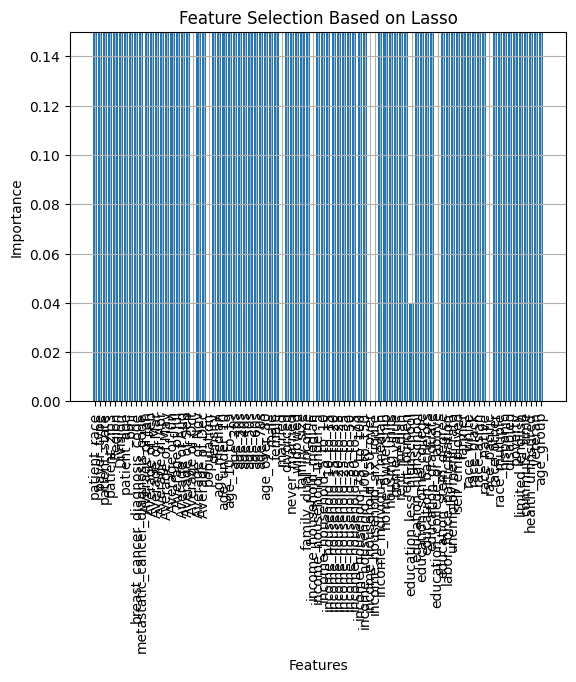

In [95]:
# Using Lasso Regressor to plot the best features

# Calling the model with the best parameter
# From the above print statements we got best parameter as {'alpha': 0.006210526315789474}
fine_lasso = Lasso(alpha=0.006210526315789474)
fine_lasso.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
fine_lasso_coef = np.abs(fine_lasso.coef_)

feature_names = clean_train.drop('metastatic_diagnosis_period', axis = 1).columns

print("Number of features in the lasso regression: ", fine_lasso.n_features_in_)
# print("Names of features in the lasso regression:\n ", fine_lasso.feature_names_in_)

print(fine_lasso_coef)

# Plotting the Column Names and Importance of Columns. 
plt.bar(feature_names, fine_lasso_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

From the plot and print out statement above, we see there are a lot of features with a coefficient of zero. This means they are not providing much value to our model. Let's find out what features are shrunk to 0 and which features were not.

In [96]:
# let's get the top 20 coefficients in lasso regression and print their respective features
# we can use this to get the name of the features:
# feature_names_in_ndarray of shape (n_features_in_,)
# Names of features seen during fit. Defined only when X has feature names that are all strings.

# and possibly this to get the number of features:
# n_features_in_int
# Number of features seen during fit.

# Here's the documentation
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Top 20 features based on absolute coefficient values:
 ['Average of Feb', 'Average of Apr', 'hispanic', 'Average of Jan', 'Average of Sep', 'home_value', 'Average of Dec', 'Average of Aug', 'Average of Jun', 'rent_median', 'patient_age', 'Average of Nov', 'payer_type', 'breast_cancer_diagnosis_code', 'age_10_to_19', 'poverty', 'race_black', 'income_household_35_to_50', 'Average of Jul', 'education_some_college']
Some of the features that shrunk to zero:
 ['metastatic_cancer_diagnosis_code', 'income_household_10_to_15', 'income_household_75_to_100', 'income_household_15_to_20', 'female', 'commute_time', 'patient_state', 'limited_english', 'health_uninsured', 'farmer', 'race_native', 'education_less_highschool', 'income_household_median', 'married', 'race_pacific', 'education_college_or_above', 'population', 'Average of Oct', 'income_household_150_over', 'income_household_six_figure']


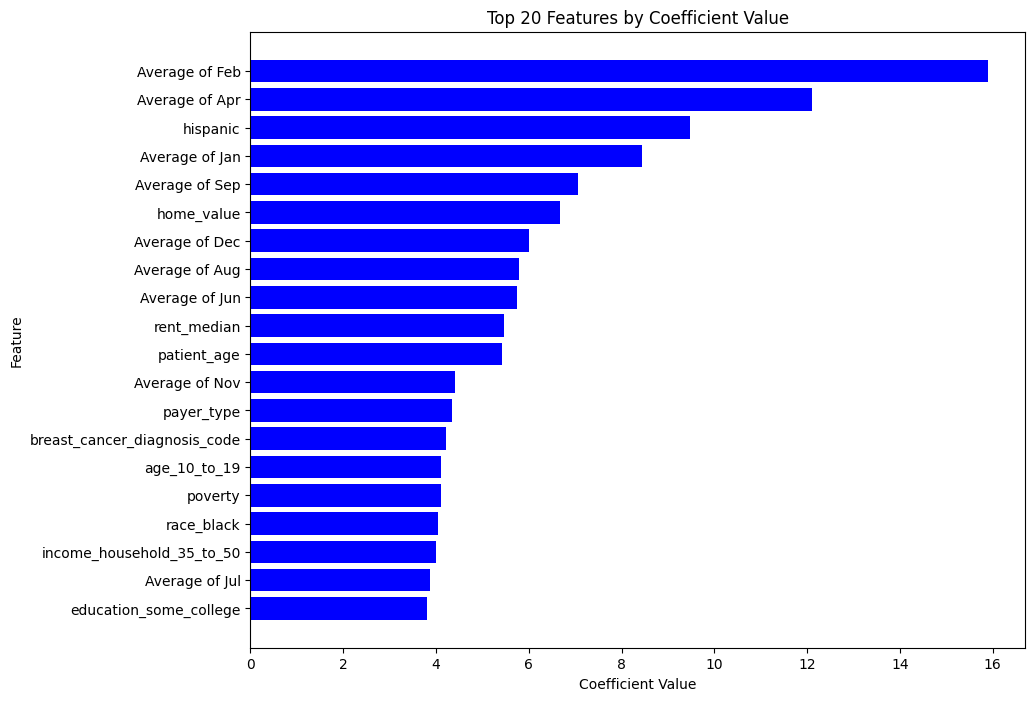

In [97]:
# Create a DataFrame to display feature names and their corresponding coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': fine_lasso_coef
})

# Sort by the (absolute) value of the coefficient
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Display the top 20 features
top_20_features = coef_df.head(20) # top 20 features that Lasso did not shrink to zero
print("Top 20 features based on absolute coefficient values:\n", top_20_features['Feature'].tolist())

# Display some of the features that lasso shrinked to zero
bottom_20_features = coef_df.tail(20)
print("Some of the features that shrunk to zero:\n", bottom_20_features['Feature'].tolist())


# Plotting the top 20 features with their coefficients
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color='b')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features by Coefficient Value')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.show()

Now we will create a new data set with the top 20 features for model training

In [98]:
model_df = clean_train[top_20_features['Feature'].tolist()] #minimizing clean_train to only 20 features
print(model_df.shape) #we should see 20 columns

(13173, 20)


# Model Training

In [99]:
# We'll be using random forest to train our model so that it can capture non linear relationships
# We'll also do another fit using ridge regression since sometimes trees can lead to overfitting

# Let's split our data again
X_model = model_df # these are our top 20 columns
y_model = clean_train['metastatic_diagnosis_period'].values


# Train Test Split (but really train validation split since we have test set to predict on)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size = 0.20, random_state = 42, stratify = y) 
# When we use an integer for random_state, the function will produce the same results across different executions.
# The results are only changed if we change the integer value.

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Validation Features: {}".format(X_val.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Validation Target: {}".format(y_val.shape))
print("\n")

# Let's create a dictionary with our machine learning models
model_dict = {
    "Ridge": (Ridge(), "regression"),
    "Random Forest Regressor": (RandomForestRegressor(), "regression"),
}
# Let's start with Ridge
ridge = Ridge()
ridge.fit(X_train, y_train) # fitting the model
print("The ridge regressor is successfully fitted:)")

y_pred_ridge = ridge.predict(X_val) #getting predictions

# Performance Metrics for Ridge Regression
print("Performance metrics for Ridge regressor: ")
# Mean Squared Error
ridge_mse = mean_squared_error(y_val, y_pred_ridge)
print("Ridge Mean Squared Error: ", ridge_mse)
# R-squared score
ridge_r2 = r2_score(y_val, y_pred_ridge)
print("Ridge r2 score: ", ridge_r2)
print("\n")


# Now let's run the Random Forest model
forest = RandomForestRegressor(random_state=42,max_depth=6)
forest.fit(X_train, y_train)
print("The random forest regressor is successfully fitted:)")
y_pred_forest = forest.predict(X_val)

# Performance Metrics for Random Forest
print("Performance metrics for Random forest regressor: ")
# Mean Squared Error
forest_mse = mean_squared_error(y_val, y_pred_forest)
print("Forest Mean Squared Error: ", forest_mse)
# R-squared score
forest_r2 = r2_score(y_val, y_pred_forest)
print("Forest r2 score: ", forest_r2)


Shape of Train Features: (10538, 20)
Shape of Validation Features: (2635, 20)
Shape of Train Target: (10538,)
Shape of Validation Target: (2635,)


The ridge regressor is successfully fitted:)
Performance metrics for Ridge regressor: 
Ridge Mean Squared Error:  8325.179620202389
Ridge r2 score:  0.29329976993572693


The random forest regressor is successfully fitted:)
Performance metrics for Random forest regressor: 
Forest Mean Squared Error:  6531.036507777064
Forest r2 score:  0.4455993488231773


(array([1229.,  339.,  165.,  110.,  155.,  143.,  127.,  173.,  108.,
          86.]),
 array([  0. ,  36.5,  73. , 109.5, 146. , 182.5, 219. , 255.5, 292. ,
        328.5, 365. ]),
 <BarContainer object of 10 artists>)

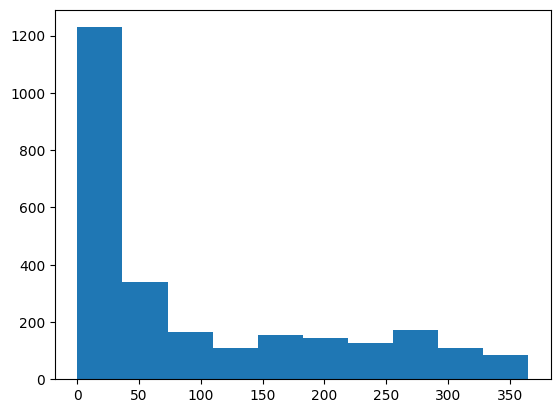

In [100]:
plt.hist(y_val)

(array([ 101., 1847.,   61.,    3.,    7.,    3.,   10.,  151.,  363.,
          89.]),
 array([ 25.14834598,  49.15056073,  73.15277549,  97.15499024,
        121.15720499, 145.15941975, 169.1616345 , 193.16384925,
        217.16606401, 241.16827876, 265.17049351]),
 <BarContainer object of 10 artists>)

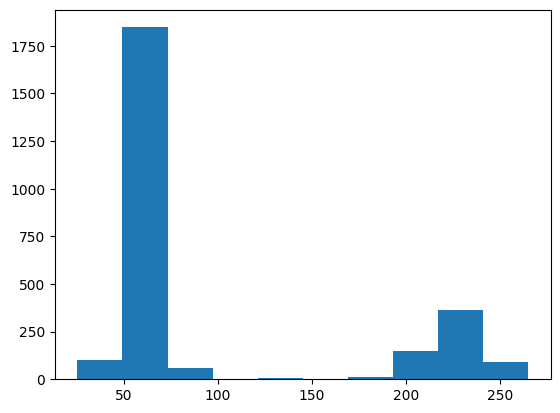

In [101]:
plt.hist(y_pred_forest)

From the output above we see that r2 score for random forest is higher than ridge regression. 

Meaning, the forest model has a higher percentage of explaining variance in our independent/outcome variable.

On the other hand, we see that the MSE for forest model is lower than of ridge.

Meaning, a smaller percentage of data points are dispersed widely around the mean in the random forest model compared to ridge model.

Given the 2 comparisons,we'll be picking random forest as our final model. We still have room for more improvement in our forest model, so we'll perform model validation to possibly increase our r2 score and decrease our MSE.

# Model Evaluation and Submission

After seeing how model works by validating our train data, we'll now use the model to predict on the test data.

In [102]:
# Using random forest model
submission = solution_template.copy()
# Minimizing clean_test to only 20 features
model_test = clean_test[top_20_features['Feature'].tolist()]
# Predicting on test set
submission['metastatic_diagnosis_period'] = forest.predict( model_test)

In [103]:
submission.to_csv('submission.csv', index=False)
submission.head()

,patient_id,metastatic_diagnosis_period
0,730681,197.779951
1,334212,63.586216
2,571362,217.186095
3,907331,224.670767
4,208382,58.998393


<Axes: >

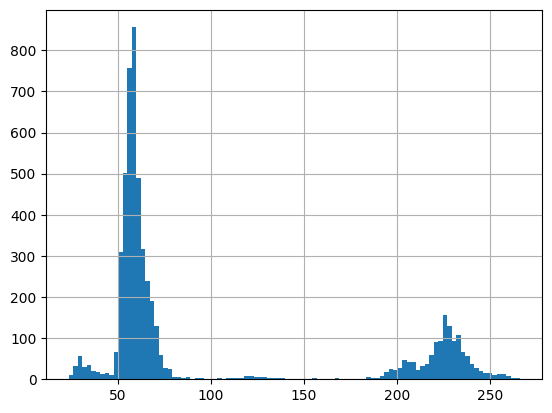

In [104]:
submission['metastatic_diagnosis_period'].hist(bins=100)

We see a surge of frequency at the around the 5o mark. It seems that it takes under 100 days for most of the diagnoses.

# Submission and Notes

Next steps to consider:
* Fine tuning the model
* Using multiple ensemble models
* Creating more visualizations for the 200-250 range for metastatic_diagnosis_period.
